In [3]:
# # adjsut the basic logging lovel of notebook
# import logging
# logging.basicConfig(level=logging.WARNING)

import os
import yaml
import numpy as np
import pandas as pd
import scipy as scp
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.lines import Line2D
from palettable.colorbrewer import qualitative
from auditory_cortex.dataloader import DataLoader
from auditory_cortex.models import Regression

from auditory_cortex.analyses import Correlations, STRFCorrelations
from auditory_cortex import results_dir, aux_dir, saved_corr_dir, cache_dir
from auditory_cortex.utils import CorrelationUtils
from auditory_cortex.plotters.correlation_plotter import RegPlotter
from auditory_cortex import utils

from pycolormap_2d import ColorMap2DBremm, ColorMap2DZiegler
%matplotlib inline

#### natual sounds (48 KHz)

In [2]:
def get_session_median(model_name, identifier):
	corr_obj = Correlations(model_name +'_'+identifier)
	dist = corr_obj.get_selected_data(
		sessions=[200206],
		bin_width=50,
		# threshold=0.114,
		mVocs=True,
		layer=10,
		)['mVocs_test_cc_raw']
	print(dist.median())

In [25]:
# model_name = 'w2v2_generic'
model_name = 'wav2vec2'
identifier = 'mVocs_corrected'
get_session_median(model_name, identifier)

Using default normalizer file...
0.19932646711209456


In [26]:
# model_name = 'w2v2_generic'
model_name = 'w2v2_audioset'
identifier = 'mVocs_corrected'
get_session_median(model_name, identifier)

Using default normalizer file...
0.20597391317104324


In [27]:
model_name = 'w2v2_generic'
identifier = 'mVocs'
get_session_median(model_name, identifier)

Using default normalizer file...
0.2105057086654179


In [28]:
model_name = 'w2v2_generic'
identifier = 'mVocs_v0'
get_session_median(model_name, identifier)

Using default normalizer file...
0.19878841440851813


In [3]:
model_name = 'w2v2_generic'
identifier = 'mVocs_test_v0'
get_session_median(model_name, identifier)

Using default normalizer file...
0.2067878942992818


In [4]:
model_name = 'w2v2_generic'
identifier = 'mVocs_test_v2'
get_session_median(model_name, identifier)

Using default normalizer file...
0.0584098051481937


In [8]:
baseline_identifier = f"STRF_freqs80_mVocs"
strf_obj = STRFCorrelations(baseline_identifier)
dist = strf_obj.get_selected_data(
		sessions=[200206],
		bin_width=50,
		mVocs=True,
		)['mVocs_test_cc_raw']
print(dist.median())

0.2663660694874011


#### previous...

Text(0, 0.5, 'correlation')

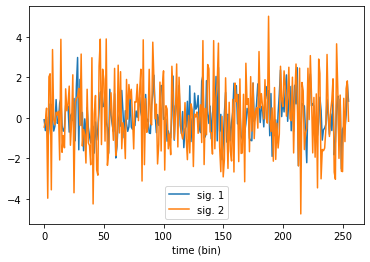

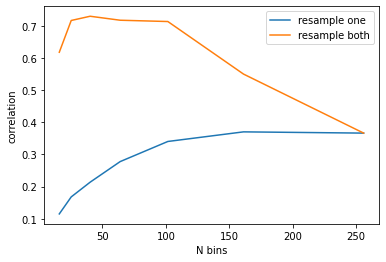

In [19]:
# ```
# %reset -s -f
# %load_ext autoreload
# %autoreload 2
    
from utils_jgm.toolbox import r_pearson
from scipy.signal import resample
import pickle
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng()

# 256 bins
logT = 8

# generate correlated random sequences with power at all frequencies
T = 2**logT
x1 = rng.normal(size=T)
x2 = x1 + rng.normal(size=T)

downsample_factor = 2
# wipe out high-freq. info
x2 = resample(x2, T//downsample_factor)
x2 = resample(x2, T)

# replace with some other high-freq. signal
u2 = 2*rng.normal(size=T)  # keep variance the same
v2 = resample(u2, T//downsample_factor)    # get a LPFed version
v2 = resample(v2, T)       #
u2 -= v2               # retain only high-freq. info
x2 += u2

# plot these sequences together
fig, ax = plt.subplots()
ax.plot(x1, label='sig. 1')
ax.plot(x2, label='sig. 2')
ax.set_xlabel('time (bin)')
ax.legend()

# init
Ts = np.logspace(logT, 4, logT-1, base=2)
r_resample_one = np.zeros_like(Ts)
r_resample_both = np.zeros_like(Ts)

# ...
for i, t in enumerate(Ts):
    t = int(t)

    # resample x1 and correlate
    y1 = resample(x1, t)
    z1 = resample(y1, T)
    r_resample_one[i] = r_pearson(z1, x2)[0,0]

    # also resample x2 and then correlate
    y2 = resample(x2, t)
    z2 = resample(y2, T)
    r_resample_both[i] = r_pearson(z1, z2)[0,0]

# correlations vs. N bins of downsampled signal
fig, ax = plt.subplots()
ax.plot(Ts, r_resample_one, label='resample one')
ax.plot(Ts, r_resample_both, label='resample both')
ax.legend()
ax.set_xlabel('N bins')
ax.set_ylabel('correlation')

# # MI vs. N bins of downsampled signal
# def jointly_Gaussian_MI(rho):
#     return -np.log2(1 - rho**2)/2
# fig, ax = plt.subplots()     
# ax.plot(Ts, jointly_Gaussian_MI(r_resample_one), label='resample one')
# ax.plot(Ts, jointly_Gaussian_MI(r_resample_both), label='resample both')
# ax.legend()
# ax.set_xlabel('N bins')
# ax.set_ylabel('mutual information')


In [7]:
Ts = np.logspace(logT, 2, logT-1, base=2)
Ts

array([256., 128.,  64.,  32.,  16.,   8.,   4.])

### timit vs mVocs: Normalizers comparison..

In [25]:
model_name = 'whisper_tiny'
identifier = 'timit'

corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

Using default normalizer file...


Text(0.5, 1.0, 'core')

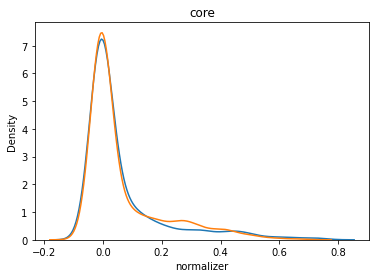

In [29]:
layer = 2
neural_area = 'core'
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)
data_subset = corr_obj.get_selected_data(
	area_sessions, layer=layer
)


sns.kdeplot(data_subset, x='normalizer')
sns.kdeplot(data_subset, x='mVocs_normalizer')
plt.title(neural_area)





# fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
# plt.suptitle(f"{neural_area}")
# ax = axes[0]
# med = np.median(data_subset['normalizer'])


# ax.hist(data_subset['normalizer'])
# ax.axvline(med, color='red')
# ax.set_title(f"stimuli: timit, med: {med:.3f}")

# ax = axes[1]
# med = np.median(data_subset['mVocs_normalizer'])
# ax.hist(data_subset['mVocs_normalizer'])
# ax.axvline(med, color='red')
# ax.set_title(f"stimuli: mVocs, med: {med:.3f}")

Text(0.5, 1.0, 'non-primary')

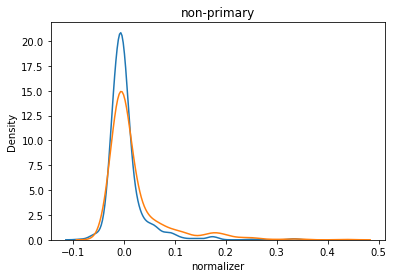

In [30]:
layer = 2
neural_area = 'non-primary'
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)
data_subset = corr_obj.get_selected_data(
	area_sessions, layer=layer
)


sns.kdeplot(data_subset, x='normalizer')
sns.kdeplot(data_subset, x='mVocs_normalizer')
plt.title(neural_area)

Text(0.5, 1.0, 'all')

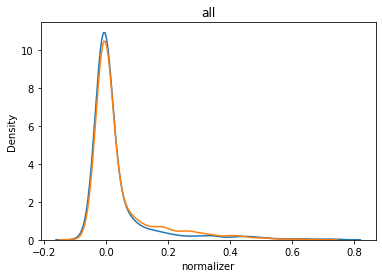

In [31]:
layer = 2
neural_area = 'all'
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)
data_subset = corr_obj.get_selected_data(
	area_sessions, layer=layer
)


sns.kdeplot(data_subset, x='normalizer')
sns.kdeplot(data_subset, x='mVocs_normalizer')
plt.title(neural_area)

Text(0.5, 1.0, 'stimuli: mVocs, med: 0.000')

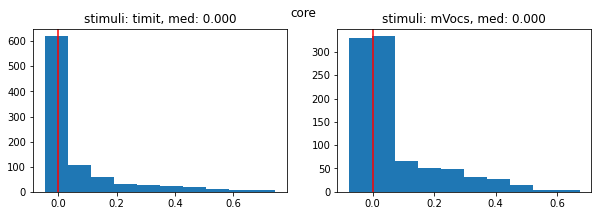

In [3]:
layer = 2
neural_area = 'core'
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)
data_subset = corr_obj.get_selected_data(
	area_sessions, layer=layer
)
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
plt.suptitle(f"{neural_area}")
ax = axes[0]
med = np.median(data_subset['normalizer'])


ax.hist(data_subset['normalizer'])
ax.axvline(med, color='red')
ax.set_title(f"stimuli: timit, med: {med:.3f}")

ax = axes[1]
med = np.median(data_subset['mVocs_normalizer'])
ax.hist(data_subset['mVocs_normalizer'])
ax.axvline(med, color='red')
ax.set_title(f"stimuli: mVocs, med: {med:.3f}")

Text(0.5, 1.0, 'stimuli: mVocs, med: -0.001')

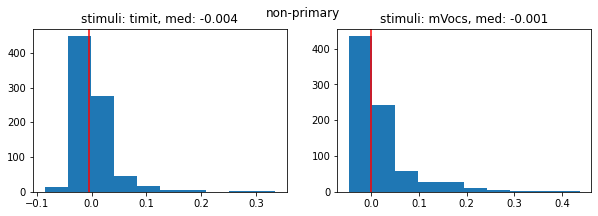

In [4]:
layer = 2
neural_area = 'non-primary'
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)
data_subset = corr_obj.get_selected_data(
	area_sessions, layer=layer
)
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
plt.suptitle(f"{neural_area}")
ax = axes[0]
med = np.median(data_subset['normalizer'])
ax.hist(data_subset['normalizer'])
ax.axvline(med, color='red')
ax.set_title(f"stimuli: timit, med: {med:.3f}")

ax = axes[1]
med = np.median(data_subset['mVocs_normalizer'])
ax.hist(data_subset['mVocs_normalizer'])
ax.axvline(med, color='red')
ax.set_title(f"stimuli: mVocs, med: {med:.3f}")

Text(0.5, 1.0, 'stimuli: mVocs, med: 0.000')

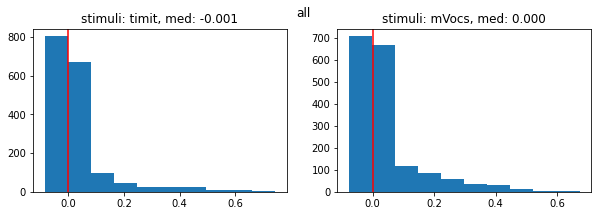

In [5]:
layer = 2
neural_area = 'all'
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)
data_subset = corr_obj.get_selected_data(
	area_sessions, layer=layer
)
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
plt.suptitle(f"{neural_area}")
ax = axes[0]
med = np.median(data_subset['normalizer'])
ax.hist(data_subset['normalizer'])
ax.axvline(med, color='red')
ax.set_title(f"stimuli: timit, med: {med:.3f}")

ax = axes[1]
med = np.median(data_subset['mVocs_normalizer'])
ax.hist(data_subset['mVocs_normalizer'])
ax.axvline(med, color='red')
ax.set_title(f"stimuli: mVocs, med: {med:.3f}")

##### sig sessions and channels...

In [3]:
from auditory_cortex.plotters.coordinates_plotter import CoordinatesPlotter

plotter = CoordinatesPlotter()

In [5]:
stim_wise_sessions = {}

In [18]:
def timi_mVocs_comparison(neural_area):
	layer = 2
	bin_width = 50
	stim_wise_sessions = {}
	# neural_area = 'core'
	mVocs = False
	area_sessions = corr_obj.metadata.get_all_sessions(neural_area)
	threshold = corr_obj.get_normalizer_threshold(
		bin_width=bin_width, poisson_normalizer=True, mVocs=mVocs)
	data_subset = corr_obj.get_selected_data(
		area_sessions, bin_width=bin_width, layer=layer, threshold=threshold, mVocs=mVocs
	)
	sig_sessions = data_subset['session'].unique()
	sig_sessions_and_channels = {}
	timit_channels_ids = []
	for sess in sig_sessions:
		channels = data_subset[data_subset['session']==sess]['channel']
		sig_sessions_and_channels[sess] = channels
		for ch in channels:
			timit_channels_ids.append(f"{int(sess)}_{int(ch)}")

	stim_wise_sessions['timit'] = sig_sessions

	mVocs = True
	area_sessions = corr_obj.metadata.get_all_sessions(neural_area)
	threshold = corr_obj.get_normalizer_threshold(
		bin_width=bin_width, poisson_normalizer=True, mVocs=mVocs)
	data_subset = corr_obj.get_selected_data(
		area_sessions, bin_width=bin_width, layer=layer, threshold=threshold, mVocs=mVocs
	)
	sig_sessions = data_subset['session'].unique()
	sig_sessions_and_channels = {}
	mVocs_channels_ids = []
	for sess in sig_sessions:
		channels = data_subset[data_subset['session']==sess]['channel']
		sig_sessions_and_channels[sess] = channels
		for ch in channels:
			mVocs_channels_ids.append(f"{int(sess)}_{int(ch)}")

	stim_wise_sessions['mVocs'] = sig_sessions
	mVocs_channels_ids = np.array(mVocs_channels_ids)
	timit_channels_ids = np.array(timit_channels_ids)

	overlapping_channels = mVocs_channels_ids[np.isin(mVocs_channels_ids, timit_channels_ids)]
	print(f"For neural area: {neural_area}")
	print(f"\t 'timit' sig. channels={timit_channels_ids.size}")
	print(f"\t 'mVocs' sig. channels={mVocs_channels_ids.size}")
	print(f"\t overlapping channels={overlapping_channels.size}")


	timit_sessions = stim_wise_sessions['timit']
	mVocs_sessions = stim_wise_sessions['mVocs']
	overlapping = timit_sessions[np.isin(timit_sessions, mVocs_sessions)]
	sess_special_colors = {sess:'k' for sess in overlapping}
	print(f"For sessions:")
	print(f"\t 'timit' sig. sessions={timit_sessions.size}")
	print(f"\t 'mVocs' sig. sessions={mVocs_sessions.size}")
	print(f"\t overlapping sessions={overlapping.size}")
	fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
	plt.suptitle(f"{neural_area}")
	ax = axes[0]
	stim = 'timit'
	sig_sessions = timit_sessions
	ax = plotter.display_session_coordinates(
		sig_sessions, ax=ax, annotate=False,
		sess_special_colors=sess_special_colors,
		)
	ax.set_title(f"stimuli: {stim}, # sessions={sig_sessions.size}")

	ax = axes[1]
	stim = 'mVocs'
	sig_sessions = mVocs_sessions
	ax = plotter.display_session_coordinates(
		sig_sessions, ax=ax, annotate=False,
		sess_special_colors=sess_special_colors,
		)
	ax.set_title(f"stimuli: {stim}, # sessions={sig_sessions.size}")



Applying threshold: 0.093 on column: 'normalizer'...
Applying threshold: 0.114 on column: 'mVocs_normalizer'...
For neural area: core
	 'timit' sig. channels=199
	 'mVocs' sig. channels=204
	 overlapping channels=153
For sessions:
	 'timit' sig. sessions=14
	 'mVocs' sig. sessions=14
	 overlapping sessions=12


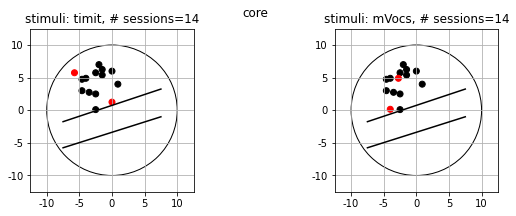

In [19]:
area='core'
timi_mVocs_comparison(area)

Applying threshold: 0.093 on column: 'normalizer'...
Applying threshold: 0.114 on column: 'mVocs_normalizer'...
For neural area: non-primary
	 'timit' sig. channels=21
	 'mVocs' sig. channels=63
	 overlapping channels=17
For sessions:
	 'timit' sig. sessions=5
	 'mVocs' sig. sessions=9
	 overlapping sessions=3


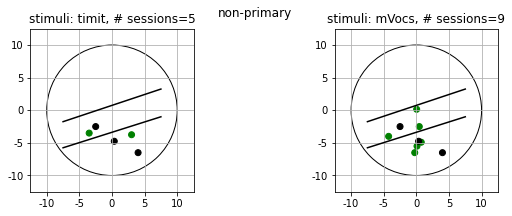

In [20]:
area='non-primary'
timi_mVocs_comparison(area)

Applying threshold: 0.093 on column: 'normalizer'...
Applying threshold: 0.114 on column: 'mVocs_normalizer'...
For neural area: all
	 'timit' sig. channels=220
	 'mVocs' sig. channels=267
	 overlapping channels=170
For sessions:
	 'timit' sig. sessions=19
	 'mVocs' sig. sessions=23
	 overlapping sessions=15


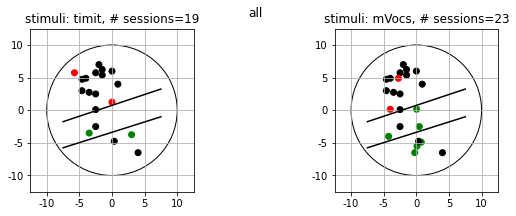

In [21]:
area='all'
timi_mVocs_comparison(area)

In [7]:
layer = 2
neural_area = 'core'
mVocs = True
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)

data_subset = corr_obj.get_selected_data(
	area_sessions, bin_width=bin_width, layer=layer, threshold=threshold, mVocs=mVocs
)
sig_sessions = data_subset['session'].unique()
sig_sessions_and_channels = {}
for sess in sig_sessions:
	channels = data_subset[data_subset['session']==sess]['channel']
	sig_sessions_and_channels[sess] = channels

print(sig_sessions.shape)
if mVocs:
	stim = 'mVocs'
else:
	stim = 'timit'

stim_wise_sessions[stim] = sig_sessions

Applying threshold: 0.093 on column: 'mVocs_normalizer'...
(14,)


# of non-overlapping sessions: 12


Text(0.5, 1.0, 'stimuli: mVocs, # sessions=14')

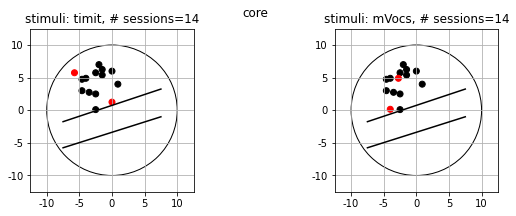

In [9]:

timit_sessions = stim_wise_sessions['timit']
mVocs_sessions = stim_wise_sessions['mVocs']
overlapping = timit_sessions[np.isin(timit_sessions, mVocs_sessions)]
sess_special_colors = {sess:'k' for sess in overlapping}
print(f"# of non-overlapping sessions: {overlapping.size}")
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
plt.suptitle(f"{neural_area}")
ax = axes[0]
stim = 'timit'
sig_sessions = timit_sessions
ax = plotter.display_session_coordinates(
	sig_sessions, ax=ax, annotate=False,
	sess_special_colors=sess_special_colors,
	)
ax.set_title(f"stimuli: {stim}, # sessions={sig_sessions.size}")

ax = axes[1]
stim = 'mVocs'
sig_sessions = mVocs_sessions
ax = plotter.display_session_coordinates(
	sig_sessions, ax=ax, annotate=False,
	sess_special_colors=sess_special_colors,
	)
ax.set_title(f"stimuli: {stim}, # sessions={sig_sessions.size}")


In [18]:
non_overlapping

array([180808., 200213.])

In [14]:
stim_wise_sessions.keys()

dict_keys(['timit', 'mVocs'])

In [32]:
stim_wise_sessions['timit']

array([180627., 180719., 180720., 180731., 180807., 180808., 180814.,
       190606., 191113., 191125., 191206., 200206., 200207., 200213.])

In [33]:
stim_wise_sessions['mVocs']

array([180627., 180719., 180720., 180731., 180807., 180814., 190606.,
       191113., 191125., 191206., 191209., 200206., 200207., 200313.])

<AxesSubplot:>

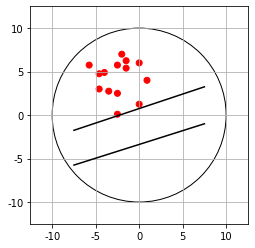

In [13]:
plotter.display_session_coordinates(stim_wise_sessions['timit'], annotate=False)

In [18]:
def display_session_coordinates(sessions=None, ax=None, annotate=True):
	if ax is None:
		fig, ax = plt.subplots()
	if sessions is None:
		sessions = corr_obj.metadata.get_all_sessions()
	plotter.plot_background(ax)
	x_coords = []
	y_coords = []
	colors = []
	for sess in sessions:
		cx, cy = plotter._get_session_coordinates(sess)
		x_coords.append(cx)
		y_coords.append(cy)
		colors.append(plotter.get_session_color(sess))

		if annotate:
			ax.annotate(sess, (cx-0.2, cy+0.05))
	ax.scatter(x_coords, y_coords, color=colors)


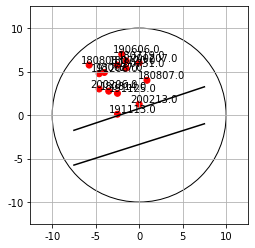

In [19]:
display_session_coordinates(stim_wise_sessions['timit'])

[-0.8, 0.98]

In [ ]:
ax = self.plot_background(ax)
for session in sessions_list:
	mini_ax = self.get_mini_axis(
		session, mini_plot_size=mini_plot_size, ax=ax
		)
	if mini_titles:
		mini_ax.set_title(f"{session}")
	mini_ax.set_axis_off()
	# pass axis as keyword argument
	mini_ax = plotting_func(session, ax=mini_ax, **kwargs)


### rest...

In [5]:
data = corr_obj.data[
	(corr_obj.data['layer'] == 2)
	]

(array([803., 672.,  97.,  46.,  26.,  24.,  26.,  11.,   7.,   6.]),
 array([-0.08545633, -0.00251992,  0.0804165 ,  0.16335291,  0.24628933,
         0.32922574,  0.41216216,  0.49509857,  0.57803499,  0.6609714 ,
         0.74390782]),
 <BarContainer object of 10 artists>)

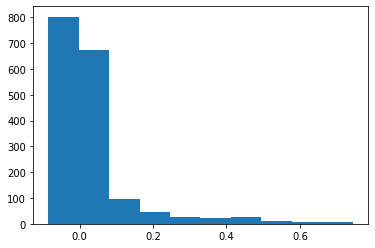

In [6]:
plt.hist(data['normalizer'])

(array([707., 667., 117.,  85.,  57.,  34.,  29.,  15.,   3.,   4.]),
 array([-0.07737716, -0.00235164,  0.07267389,  0.14769941,  0.22272494,
         0.29775046,  0.37277598,  0.44780151,  0.52282703,  0.59785255,
         0.67287808]),
 <BarContainer object of 10 artists>)

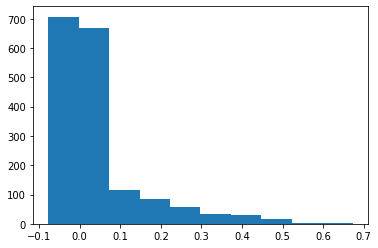

In [7]:
plt.hist(data['mVocs_normalizer'])

In [2]:
model_name = 'whisper_tiny'
identifier = 'delays_trimmed'

corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

Using default normalizer file...


In [9]:
bin_width = 50
poisson_normalizer = True


area = 'non-primary'
delay = 0
normalized=True
column = None
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

neural_area = area

In [42]:
mVocs=False
threshold = corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	mVocs=mVocs
)
print(threshold)

0.09300012805194689


In [38]:
bin_width = 50
force_redo=False
mVocs=False
null_dist = corr_obj.norm_obj.get_normalizer_null_dist_using_poisson(
	bin_width, itr=10000, force_redo=force_redo,
            mVocs=mVocs
)

np.percentile(null_dist, 95)

0.0933105676552743

In [43]:
data_dist_trained = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, mVocs=mVocs, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)
print(f"Sig. neurons= {data_dist_trained[2].shape[0]}")

Extracting column: normalized_test_cc
get_selected_data() method inside Correlations....
Applying threshold: 0.093 on column: 'normalizer'...
Sig. neurons= 21


In [51]:
bin_width = 50
poisson_normalizer = True
area = 'non-primary'
delay = 0

model_name = 'whisper_tiny'
identifier = 'delays_trimmed'

corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

neural_area = area
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)

mVocs=False
threshold = corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	mVocs=mVocs
)
print(f"Appying threshold: {threshold}")

area_sessions = [200206]
N_sents = None
select_data = corr_obj.get_selected_data(
	sessions=area_sessions, 
	bin_width=bin_width,
	delay=delay,
	threshold=threshold,
	N_sents=N_sents,
	mVocs=mVocs,
)
select_data[
	(select_data['layer'] ==2)
	# (select_data['channel'] < 20)
]

Using default normalizer file...
Appying threshold: 0.09300012805194689
get_selected_data() method inside Correlations....
Applying threshold: 0.093 on column: 'normalizer'...


,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,opt_lag,opt_lmbda,N_sents,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,layer_type,normalized_test_cc
7886,200206.0,2.0,0.0,50.0,0.0,0.288945,0.251761,0.0,0.0,500.0,3.960664,0.010484,-0.005693,transformer,0.575865
7887,200206.0,2.0,1.0,50.0,0.0,0.375698,0.328440,0.0,-1.0,500.0,2.349329,0.009712,-0.003602,transformer,0.655558
7888,200206.0,2.0,2.0,50.0,0.0,0.242419,0.139388,25.0,-1.0,500.0,8.395172,0.015140,-0.011500,transformer,0.649311
7889,200206.0,2.0,3.0,50.0,0.0,0.561763,0.568845,0.0,-1.0,500.0,2.108980,0.010945,-0.003348,transformer,0.744828
7890,200206.0,2.0,4.0,50.0,0.0,0.167793,0.174655,25.0,-1.0,500.0,3.865883,0.009906,-0.005377,transformer,0.401498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7945,200206.0,2.0,59.0,50.0,0.0,0.560217,0.629629,0.0,-1.0,500.0,56.906569,0.104054,-0.099506,transformer,0.706014
7946,200206.0,2.0,60.0,50.0,0.0,0.638078,0.610637,0.0,-2.0,500.0,217.331682,0.321913,-0.317389,transformer,0.816549
7947,200206.0,2.0,61.0,50.0,0.0,0.606739,0.615988,0.0,-1.0,500.0,10.649380,0.027583,-0.022277,transformer,0.773064
7948,200206.0,2.0,62.0,50.0,0.0,0.644998,0.548042,0.0,-6.0,500.0,26264.809894,24.430761,-24.426620,transformer,0.871267


In [7]:
model_name = 'whisper_tiny'
identifier = 'debug2_06_25_24'

corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
corr_obj.set_normalizers_using_bootsrap()

Using default normalizer file...
get_selected_data() method inside Correlations....
get_selected_data() method inside Correlations....
Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_tiny_debug2_06_25_24_corr_results.csv


Using default normalizer file...


<AxesSubplot:>

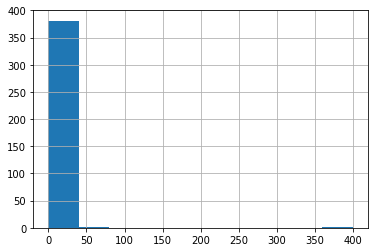

In [6]:
model_name = 'whisper_tiny'
identifier = 'debug_06_25_24'

corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
corr_obj.data['opt_lag'].hist()

In [10]:
model_name = 'whisper_tiny'
identifier = 'debug2_06_25_24'

corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
corr_obj.data.median()

Using default normalizer file...


session               200206.000000
layer                      2.500000
channel                   31.500000
bin_width                 50.000000
delay                      0.000000
test_cc_raw                0.414370
normalizer                 0.424784
mVocs_test_cc_raw          0.106715
mVocs_normalizer           0.000000
opt_lag                    0.000000
opt_lmbda                 -1.000000
N_sents                  500.000000
normalized_test_cc         0.657872
dtype: float64

In [9]:
bin_width = 50
poisson_normalizer = True
area = 'non-primary'
delay = 0

model_name = 'whisper_tiny'
identifier = 'debug2_06_25_24'

corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

neural_area = area
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)

mVocs=False
threshold = corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	mVocs=mVocs
)
print(f"Appying threshold: {threshold}")
area_sessions = [200206]
N_sents = None
select_data = corr_obj.get_selected_data(
	sessions=area_sessions, 
	bin_width=bin_width,
	delay=delay,
	threshold=threshold,
	N_sents=N_sents,
	mVocs=mVocs,
)
select_data[
	(select_data['layer'] ==2)
	# (select_data['channel'] < 20)
]

Using default normalizer file...
Appying threshold: 0.09300012805194689
get_selected_data() method inside Correlations....
Applying threshold: 0.093 on column: 'normalizer'...


,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,mVocs_test_cc_raw,mVocs_normalizer,opt_lag,opt_lmbda,N_sents,normalized_test_cc
128,200206.0,2.0,0.0,50.0,0.0,0.288945,0.251761,-0.029020,0.0,0.0,0.0,500.0,0.575866
129,200206.0,2.0,1.0,50.0,0.0,0.385230,0.328440,0.083060,0.0,20.0,-1.0,500.0,0.672190
130,200206.0,2.0,2.0,50.0,0.0,0.240124,0.139388,0.073212,0.0,20.0,-1.0,500.0,0.643165
131,200206.0,2.0,3.0,50.0,0.0,0.561763,0.568845,-0.001137,0.0,0.0,-1.0,500.0,0.744828
132,200206.0,2.0,4.0,50.0,0.0,0.154592,0.174655,-0.057513,0.0,30.0,-1.0,500.0,0.369912
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,200206.0,2.0,59.0,50.0,0.0,0.560216,0.629629,0.356968,0.0,0.0,-1.0,500.0,0.706014
188,200206.0,2.0,60.0,50.0,0.0,0.638078,0.610637,0.030395,0.0,0.0,-2.0,500.0,0.816549
189,200206.0,2.0,61.0,50.0,0.0,0.606738,0.615988,0.021187,0.0,0.0,-1.0,500.0,0.773063
190,200206.0,2.0,62.0,50.0,0.0,0.643240,0.548042,0.063923,0.0,0.0,-2.0,500.0,0.868892


In [8]:
bin_width = 50
poisson_normalizer = True
area = 'non-primary'
delay = 0

model_name = 'whisper_tiny'
identifier = 'debug_06_25_24'

corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

neural_area = area
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)

mVocs=False
threshold = corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	mVocs=mVocs
)
print(f"Appying threshold: {threshold}")
area_sessions = [200206]
N_sents = None
select_data = corr_obj.get_selected_data(
	sessions=area_sessions, 
	bin_width=bin_width,
	delay=delay,
	threshold=threshold,
	N_sents=N_sents,
	mVocs=mVocs,
)
select_data[
	(select_data['layer'] ==2)
	# (select_data['channel'] < 20)
]

Using default normalizer file...
Appying threshold: 0.09300012805194689
get_selected_data() method inside Correlations....
Applying threshold: 0.093 on column: 'normalizer'...


,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,mVocs_test_cc_raw,mVocs_normalizer,opt_lag,opt_lmbda,N_sents,normalized_test_cc
128,200206.0,2.0,0.0,50.0,0.0,0.301954,0.251761,0.0,0.0,0.0,-1.0,500.0,0.601792
129,200206.0,2.0,1.0,50.0,0.0,0.385230,0.328440,0.0,0.0,20.0,-1.0,500.0,0.672190
130,200206.0,2.0,2.0,50.0,0.0,0.226806,0.139388,0.0,0.0,20.0,0.0,500.0,0.607493
131,200206.0,2.0,3.0,50.0,0.0,0.561763,0.568845,0.0,0.0,0.0,-1.0,500.0,0.744828
132,200206.0,2.0,4.0,50.0,0.0,0.169401,0.174655,0.0,0.0,0.0,0.0,500.0,0.405347
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,200206.0,2.0,59.0,50.0,0.0,0.560217,0.629629,0.0,0.0,0.0,-1.0,500.0,0.706014
188,200206.0,2.0,60.0,50.0,0.0,0.637516,0.610637,0.0,0.0,0.0,-9.0,500.0,0.815829
189,200206.0,2.0,61.0,50.0,0.0,0.589950,0.615988,0.0,0.0,10.0,-1.0,500.0,0.751673
190,200206.0,2.0,62.0,50.0,0.0,0.644239,0.548042,0.0,0.0,0.0,-9.0,500.0,0.870242


In [57]:
corr_obj.data.median()

session               200206.000000
layer                      2.500000
channel                   31.500000
bin_width                 50.000000
delay                      0.000000
test_cc_raw                0.390770
normalizer                 0.424784
mVocs_test_cc_raw          0.000000
mVocs_normalizer           0.000000
opt_lag                    0.000000
opt_lmbda                 -3.000000
N_sents                  500.000000
normalized_test_cc         0.628292
dtype: float64

In [52]:
bin_width = 50
poisson_normalizer = True
area = 'non-primary'
delay = 0

model_name = 'whisper_tiny'
identifier = 'timit'

corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

neural_area = area
area_sessions = corr_obj.metadata.get_all_sessions(neural_area)

mVocs=False
threshold = corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	mVocs=mVocs
)
print(f"Appying threshold: {threshold}")
area_sessions = [200206]
N_sents = None
select_data = corr_obj.get_selected_data(
	sessions=area_sessions, 
	bin_width=bin_width,
	delay=delay,
	threshold=threshold,
	N_sents=N_sents,
	mVocs=mVocs,
)
select_data[
	(select_data['layer'] ==2)
	# (select_data['channel'] < 20)
]

Using default normalizer file...
Appying threshold: 0.09300012805194689
get_selected_data() method inside Correlations....
Applying threshold: 0.093 on column: 'normalizer'...


,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,mVocs_test_cc_raw,mVocs_normalizer,opt_lag,opt_lmbda,N_sents,layer_type,normalized_test_cc,mVocs_normalized_test_cc
7886,200206.0,2.0,0.0,50.0,0.0,0.726530,0.251761,-0.039790,0.165969,0.0,-10.0,500.0,transformer,1.447969,-0.097670
7887,200206.0,2.0,1.0,50.0,0.0,0.298993,0.328440,-0.027356,0.166640,0.0,-1.0,500.0,transformer,0.521715,-0.067013
7888,200206.0,2.0,2.0,50.0,0.0,0.544322,0.139388,-0.014471,0.192334,0.0,-10.0,500.0,transformer,1.457951,-0.032998
7889,200206.0,2.0,3.0,50.0,0.0,0.263072,0.568845,0.175499,0.248808,10.0,-1.0,500.0,transformer,0.348801,0.351838
7890,200206.0,2.0,4.0,50.0,0.0,0.845690,0.174655,-0.084427,0.154869,0.0,-10.0,500.0,transformer,2.023585,-0.214535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7945,200206.0,2.0,59.0,50.0,0.0,0.746838,0.629629,0.050682,0.505581,60.0,-2.0,500.0,transformer,0.941205,0.071278
7946,200206.0,2.0,60.0,50.0,0.0,0.272991,0.610637,-0.039574,0.150548,100.0,-1.0,500.0,transformer,0.349347,-0.101994
7947,200206.0,2.0,61.0,50.0,0.0,0.490310,0.615988,0.185644,0.254369,10.0,-1.0,500.0,transformer,0.624719,0.368085
7948,200206.0,2.0,62.0,50.0,0.0,0.332869,0.548042,0.044569,0.220908,10.0,-1.0,500.0,transformer,0.449641,0.094825


(21, 15)

In [33]:
N_sents = None
select_data = corr_obj.get_selected_data(
	sessions=[191210], 
	bin_width=bin_width,
	delay=delay,
	# threshold=threshold,
	N_sents=N_sents,
	mVocs=mVocs,
)

get_selected_data() method inside Correlations....


In [27]:
select_data[
	(select_data['layer'] ==2) &\
	(select_data['channel'] < 20)
]

,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,opt_lag,opt_lmbda,N_sents,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,layer_type,normalized_test_cc
6416,191210.0,2.0,0.0,50.0,0.0,0.128648,0.061196,0.0,0.0,500.0,2.150536,0.008500,-0.001537,transformer,0.520045
6417,191210.0,2.0,1.0,50.0,0.0,0.052421,0.030194,25.0,1.0,500.0,1.419938,0.014844,-0.005030,transformer,0.301676
6418,191210.0,2.0,2.0,50.0,0.0,0.076968,0.027212,0.0,1.0,500.0,1.643655,0.007528,-0.000977,transformer,0.466586
6419,191210.0,2.0,3.0,50.0,0.0,0.125846,0.065565,0.0,0.0,500.0,2.229597,0.008465,-0.001323,transformer,0.491479
6420,191210.0,2.0,4.0,50.0,0.0,0.062217,0.043537,350.0,0.0,500.0,1.931618,0.008601,-0.001183,transformer,0.298181
6421,191210.0,2.0,5.0,50.0,0.0,0.103689,0.059185,25.0,0.0,500.0,1.718389,0.009216,-0.002134,transformer,0.426210
6422,191210.0,2.0,6.0,50.0,0.0,0.163313,0.092712,0.0,0.0,500.0,2.242235,0.008380,-0.001240,transformer,0.536357
6423,191210.0,2.0,7.0,50.0,0.0,0.087735,0.041484,0.0,0.0,500.0,1.807538,0.008358,-0.001386,transformer,0.430756
6424,191210.0,2.0,8.0,50.0,0.0,0.007988,0.004835,25.0,0.0,500.0,1.579892,0.017138,-0.007695,transformer,0.114877
6425,191210.0,2.0,9.0,50.0,0.0,0.167046,0.077676,0.0,0.0,500.0,2.057167,0.007851,-0.001010,transformer,0.599367


In [15]:
corr_obj.data['session'].unique()

array([180413., 180420., 180501., 180502., 180613., 180622., 180627.,
       180717., 180719., 180720., 180724., 180728., 180730., 180731.,
       180807., 180808., 180810., 180814., 190604., 190605., 190606.,
       190703., 190726., 190801., 191113., 191115., 191121., 191125.,
       191206., 191209., 191210., 191211., 191219., 200205., 200206.,
       200207., 200212., 200213., 200219., 200313., 200318.])

(21,)

In [6]:
corr_obj.data[
	corr_obj.data['layer']==3
	# corr_obj.data['layer']==3 &\
].median()

session              200206.000000
layer                     3.000000
channel                  31.500000
bin_width                50.000000
delay                     0.000000
test_cc_raw               0.392463
normalizer                0.000000
mVocs_test_cc_raw         0.053987
mVocs_normalizer          0.000000
opt_lag                   0.000000
opt_lmbda                -1.000000
N_sents                 500.000000
dtype: float64

In [6]:
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...


In [4]:
corr_obj.data

,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,opt_lag,opt_lmbda,N_sents,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,layer_type,mVocs_test_cc_raw,mVocs_normalizer,normalized_test_cc
0,200206.0,0.0,0.0,50.0,0.0,0.135335,0.251761,400.0,-1.0,500.0,3.257402,0.001245,-0.000530,conv,0.135335,0.0,0.269723
1,200206.0,0.0,1.0,50.0,0.0,0.291802,0.328440,0.0,-2.0,500.0,2.635073,0.000967,-0.000427,conv,0.291802,0.0,0.509167
2,200206.0,0.0,2.0,50.0,0.0,0.218357,0.139388,0.0,-3.0,500.0,1.265132,0.002145,-0.001064,conv,0.218357,0.0,0.584864
3,200206.0,0.0,3.0,50.0,0.0,0.091474,0.568845,350.0,-3.0,500.0,2.437992,0.001300,-0.000506,conv,0.091474,0.0,0.121283
4,200206.0,0.0,4.0,50.0,0.0,0.201839,0.174655,300.0,-1.0,500.0,3.085355,0.001056,-0.000431,conv,0.201839,0.0,0.482965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12747,200318.0,7.0,40.0,50.0,0.0,0.219706,0.016607,60.0,2.0,500.0,1.813352,0.001149,-0.000356,transformer,0.219706,0.0,1.704873
12748,200318.0,7.0,41.0,50.0,0.0,0.023181,-0.005725,400.0,2.0,500.0,1.803841,0.001694,-0.000589,transformer,0.023181,0.0,NaN
12749,200318.0,7.0,42.0,50.0,0.0,0.112630,0.001004,400.0,2.0,500.0,1.646354,0.001809,-0.000607,transformer,0.112630,0.0,3.554889
12750,200318.0,7.0,43.0,50.0,0.0,-0.016377,-0.011555,350.0,3.0,500.0,1.651826,0.001846,-0.000614,transformer,-0.016377,0.0,NaN


In [5]:
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...


In [6]:
corr_obj.data

,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,opt_lag,opt_lmbda,N_sents,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,layer_type,mVocs_test_cc_raw,mVocs_normalizer,normalized_test_cc,mVocs_normalized_test_cc
0,200206.0,0.0,0.0,50.0,0.0,0.135335,0.251761,400.0,-1.0,500.0,3.257402,0.001245,-0.000530,conv,0.135335,0.251761,0.269723,0.269723
1,200206.0,0.0,1.0,50.0,0.0,0.291802,0.328440,0.0,-2.0,500.0,2.635073,0.000967,-0.000427,conv,0.291802,0.328440,0.509167,0.509167
2,200206.0,0.0,2.0,50.0,0.0,0.218357,0.139388,0.0,-3.0,500.0,1.265132,0.002145,-0.001064,conv,0.218357,0.139388,0.584864,0.584864
3,200206.0,0.0,3.0,50.0,0.0,0.091474,0.568845,350.0,-3.0,500.0,2.437992,0.001300,-0.000506,conv,0.091474,0.568845,0.121283,0.121283
4,200206.0,0.0,4.0,50.0,0.0,0.201839,0.174655,300.0,-1.0,500.0,3.085355,0.001056,-0.000431,conv,0.201839,0.174655,0.482965,0.482965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12747,200318.0,7.0,40.0,50.0,0.0,0.219706,0.016607,60.0,2.0,500.0,1.813352,0.001149,-0.000356,transformer,0.219706,0.016607,1.704873,1.704873
12748,200318.0,7.0,41.0,50.0,0.0,0.023181,-0.005725,400.0,2.0,500.0,1.803841,0.001694,-0.000589,transformer,0.023181,-0.005725,NaN,NaN
12749,200318.0,7.0,42.0,50.0,0.0,0.112630,0.001004,400.0,2.0,500.0,1.646354,0.001809,-0.000607,transformer,0.112630,0.001004,3.554889,3.554889
12750,200318.0,7.0,43.0,50.0,0.0,-0.016377,-0.011555,350.0,3.0,500.0,1.651826,0.001846,-0.000614,transformer,-0.016377,-0.011555,NaN,NaN


In [5]:
corr_obj.data.columns

Index(['session', 'layer', 'channel', 'bin_width', 'delay', 'test_cc_raw',
       'normalizer', 'opt_lag', 'opt_lmbda', 'N_sents', 'poiss_entropy',
       'uncertainty_per_spike', 'bits_per_spike_NLB', 'layer_type',
       'mVocs_test_cc_raw', 'mVocs_normalizer'],
      dtype='object')

### adding extra columns for mVocs...

In [5]:
model_names = [
	'wav2letter_modified', 'whisper_base', 'whisper_tiny',
	'deepspeech2',
	'speech2text',
	'wav2vec2',
	'w2v2_audioset'
	]

identifier = 'mVocs_corrected'
# identifier = 'reset_mVocs_corrected'
for model_name in model_names:
	corr_obj = Correlations(
			model_name=model_name+'_'+identifier,
			)
	corr_obj.set_normalizers_using_bootsrap(mVocs=True)


	# corr_obj.data['mVocs_test_cc_raw'] = corr_obj.data['test_cc_raw']  
	# corr_obj.data['mVocs_normalizer'] = corr_obj.data['normalizer']
	# corr_obj.write_back() 

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_modified_mVocs_corrected_corr_results.csv
Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_mVocs_corrected_corr_results.csv
Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_tiny_mVocs_corrected_corr_results.csv
Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw'

In [6]:
corr_obj.data

,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,opt_lag,opt_lmbda,N_sents,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,layer_type,mVocs_test_cc_raw
0,200206.0,0.0,0.0,50.0,0.0,0.135335,0.0,400.0,-1.0,500.0,3.257402,0.001245,-0.000530,conv,0.135335
1,200206.0,0.0,1.0,50.0,0.0,0.291802,0.0,0.0,-2.0,500.0,2.635073,0.000967,-0.000427,conv,0.291802
2,200206.0,0.0,2.0,50.0,0.0,0.218357,0.0,0.0,-3.0,500.0,1.265132,0.002145,-0.001064,conv,0.218357
3,200206.0,0.0,3.0,50.0,0.0,0.091474,0.0,350.0,-3.0,500.0,2.437992,0.001300,-0.000506,conv,0.091474
4,200206.0,0.0,4.0,50.0,0.0,0.201839,0.0,300.0,-1.0,500.0,3.085355,0.001056,-0.000431,conv,0.201839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12747,200318.0,7.0,40.0,50.0,0.0,0.219706,0.0,60.0,2.0,500.0,1.813352,0.001149,-0.000356,transformer,0.219706
12748,200318.0,7.0,41.0,50.0,0.0,0.023181,0.0,400.0,2.0,500.0,1.803841,0.001694,-0.000589,transformer,0.023181
12749,200318.0,7.0,42.0,50.0,0.0,0.112630,0.0,400.0,2.0,500.0,1.646354,0.001809,-0.000607,transformer,0.112630
12750,200318.0,7.0,43.0,50.0,0.0,-0.016377,0.0,350.0,3.0,500.0,1.651826,0.001846,-0.000614,transformer,-0.016377


Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_mVocs_corrected_corr_results.csv


### mVoc vs previous results..

Using default normalizer file...


Text(0.5, 1.0, '200206, median: 0.3290844583074472')

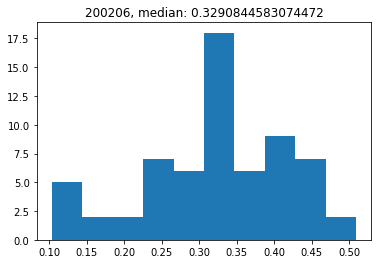

In [25]:
model_name = 'whisper_base'
identifier = 'mVocs'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

area = 'non-primary'
# threshold = 0.06
bin_width=50
layer = 2
sessions = corr_obj.metadata.get_all_sessions(area)
sessions = [200206]
sig_data = corr_obj.get_selected_data(sessions=sessions, bin_width=bin_width, layer=layer,
# , threshold=threshold
)

plt.hist(sig_data['test_cc_raw'])
plt.title(f"200206, median: {np.median(sig_data['test_cc_raw'])}")

Using default normalizer file...


Text(0.5, 1.0, '200206, median: 0.17117193291255126')

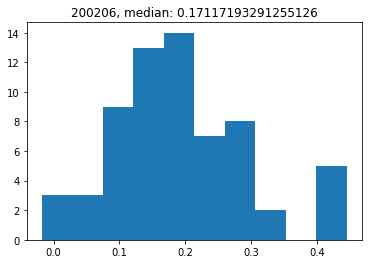

In [28]:
model_name = 'whisper_base'
# model_name = 'whisper_tiny'
identifier = 'test_reg4'
# identifier = 'delays_trimmed'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
area = 'non-primary'
# threshold = 0.06
bin_width=50
layer = 2
sessions = corr_obj.metadata.get_all_sessions(area)
sessions = [200206]
sig_data = corr_obj.get_selected_data(sessions=sessions, bin_width=bin_width, layer=layer,
# , threshold=threshold
)
plt.hist(sig_data['test_cc_raw'])
plt.title(f"200206, median: {np.median(sig_data['test_cc_raw'])}")

Using default normalizer file...


Text(0.5, 1.0, '200206, median: 0.23793724019900186')

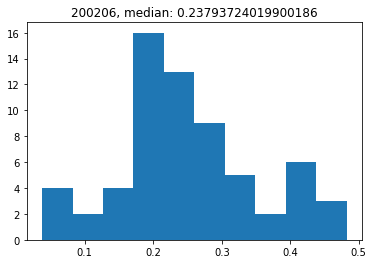

In [3]:
model_name = 'whisper_base'
# model_name = 'whisper_tiny'
identifier = 'test_reg5'
# identifier = 'delays_trimmed'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
area = 'non-primary'
# threshold = 0.06
bin_width=50
layer = 2
sessions = corr_obj.metadata.get_all_sessions(area)
sessions = [200206]
sig_data = corr_obj.get_selected_data(sessions=sessions, bin_width=bin_width, layer=layer,
# , threshold=threshold
)
plt.hist(sig_data['test_cc_raw'])
plt.title(f"200206, median: {np.median(sig_data['test_cc_raw'])}")

Using default normalizer file...


Text(0.5, 1.0, '200206, median: 0.45049766032227156')

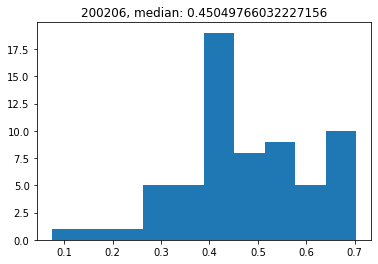

In [27]:
model_name = 'whisper_base'
# model_name = 'whisper_tiny'
identifier = 'trimmed_fine'
# identifier = 'delays_trimmed'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
area = 'non-primary'
# threshold = 0.06
bin_width=50
layer = 2
sessions = corr_obj.metadata.get_all_sessions(area)
sessions = [200206]
sig_data = corr_obj.get_selected_data(sessions=sessions, bin_width=bin_width, layer=layer,
# , threshold=threshold
)
plt.hist(sig_data['test_cc_raw'])
plt.title(f"200206, median: {np.median(sig_data['test_cc_raw'])}")

Using default normalizer file...


Text(0.5, 1.0, '200206, median: 0.40192415562212114')

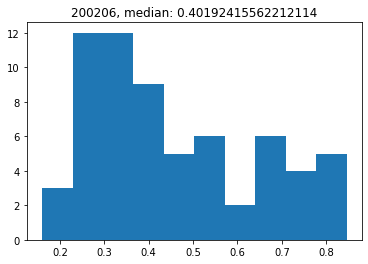

In [20]:
model_name = 'whisper_tiny'
identifier = 'test_reg'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
area = 'non-primary'
# threshold = 0.06
bin_width=50
layer = 2
sessions = corr_obj.metadata.get_all_sessions(area)
sessions = [200206]
sig_data = corr_obj.get_selected_data(sessions=sessions, bin_width=bin_width, layer=layer,
# , threshold=threshold
)
plt.hist(sig_data['test_cc_raw'])
plt.title(f"200206, median: {np.median(sig_data['test_cc_raw'])}")

Using default normalizer file...


Text(0.5, 1.0, '200206, median: 0.401924168849865')

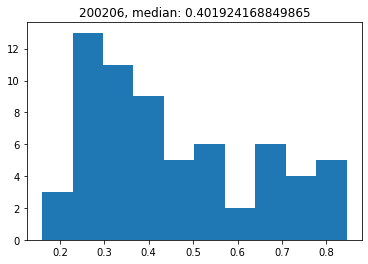

In [21]:
model_name = 'whisper_tiny'
identifier = 'test_reg2'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
area = 'non-primary'
# threshold = 0.06
bin_width=50
layer = 2
sessions = corr_obj.metadata.get_all_sessions(area)
sessions = [200206]
sig_data = corr_obj.get_selected_data(sessions=sessions, bin_width=bin_width, layer=layer,
# , threshold=threshold
)
plt.hist(sig_data['test_cc_raw'])
plt.title(f"200206, median: {np.median(sig_data['test_cc_raw'])}")

Using default normalizer file...


Text(0.5, 1.0, '200206, median: 0.40192416391084107')

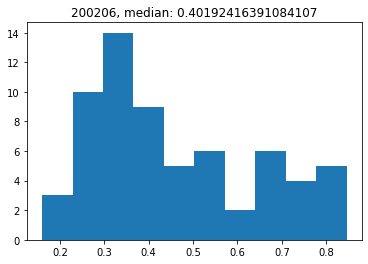

In [22]:
model_name = 'whisper_tiny'
identifier = 'test_reg3'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
area = 'non-primary'
# threshold = 0.06
bin_width=50
layer = 2
sessions = corr_obj.metadata.get_all_sessions(area)
sessions = [200206]
sig_data = corr_obj.get_selected_data(sessions=sessions, bin_width=bin_width, layer=layer,
# , threshold=threshold
)
plt.hist(sig_data['test_cc_raw'])
plt.title(f"200206, median: {np.median(sig_data['test_cc_raw'])}")

Using default normalizer file...


Text(0.5, 1.0, '200206, median: 0.15722329941456945')

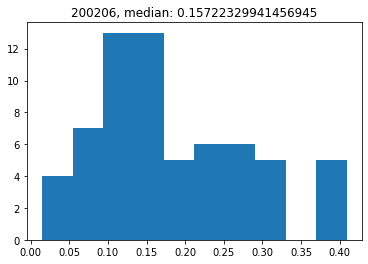

In [23]:
model_name = 'whisper_tiny'
identifier = 'test_reg4'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
area = 'non-primary'
# threshold = 0.06
bin_width=50
layer = 2
sessions = corr_obj.metadata.get_all_sessions(area)
sessions = [200206]
sig_data = corr_obj.get_selected_data(sessions=sessions, bin_width=bin_width, layer=layer,
# , threshold=threshold
)
plt.hist(sig_data['test_cc_raw'])
plt.title(f"200206, median: {np.median(sig_data['test_cc_raw'])}")

In [18]:
sig_data['opt_lmbda']

128   -10.0
129    -1.0
130   -10.0
131    -1.0
132   -10.0
       ... 
187   -10.0
188    -1.0
189    -1.0
190    -1.0
191    -1.0
Name: opt_lmbda, Length: 64, dtype: float64

In [6]:
sig_data['test_cc_raw']

,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,opt_lag,opt_lmbda,N_sents,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB
9992,200206.0,2.0,0.0,50.0,0.0,0.303311,0.0,400.0,-1.0,500.0,2.719797,0.000683,-0.000263
9993,200206.0,2.0,1.0,50.0,0.0,0.318793,0.0,400.0,-2.0,500.0,2.053156,0.000902,-0.000364
9994,200206.0,2.0,2.0,50.0,0.0,0.336636,0.0,40.0,-2.0,500.0,1.197844,0.001716,-0.000969
9995,200206.0,2.0,3.0,50.0,0.0,0.400964,0.0,50.0,-2.0,500.0,2.955174,0.000679,-0.000330
9996,200206.0,2.0,4.0,50.0,0.0,0.280463,0.0,350.0,-1.0,500.0,2.464134,0.000636,-0.000222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10051,200206.0,2.0,59.0,50.0,0.0,0.439821,0.0,400.0,-3.0,500.0,15.989211,0.002226,-0.001855
10052,200206.0,2.0,60.0,50.0,0.0,0.112971,0.0,400.0,-2.0,500.0,1.256986,0.002264,-0.001294
10053,200206.0,2.0,61.0,50.0,0.0,0.430397,0.0,40.0,-2.0,500.0,4.639154,0.000860,-0.000536
10054,200206.0,2.0,62.0,50.0,0.0,0.299478,0.0,20.0,-2.0,500.0,1.496575,0.001017,-0.000418


In [14]:
bin_width=50
area = 'core'
corr_obj.get_significant_sessions(bin_width=bin_width, 
# neural_area=area
)

Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..


array([180613., 180627., 180719., 180720., 180728., 180730., 180731.,
       180807., 180808., 180814., 190606., 191113., 191121., 191125.,
       191206., 191210., 200205., 200206., 200207., 200213., 200219.])

In [19]:
sig_sessions = np.array([180613., 180627., 180719., 180720., 180728., 180730., 180731.,
						180807., 180808., 180814., 190606., 191113., 191121., 191125.,
						191206., 191210., 200205., 200206., 200207., 200213., 200219.])

sig_sessions.astype(int)

array([180613, 180627, 180719, 180720, 180728, 180730, 180731, 180807,
       180808, 180814, 190606, 191113, 191121, 191125, 191206, 191210,
       200205, 200206, 200207, 200213, 200219])

In [12]:
bin_width=50
area = 'non-primary'
corr_obj.get_significant_sessions(bin_width=bin_width, neural_area=area).shape

Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..


(7,)

In [7]:
null_dist = corr_obj.norm_obj.get_normalizer_null_dist_using_poisson(bin_width=bin_width)

p_value = 5
q = 100 - p_value
np.percentile(null_dist, q)

0.09309249628891103

In [10]:
corr_obj.get_normalizer_threshold(bin_width, True)

Reading exisiting normalizer thresholds...


0.09141104242592994

In [9]:
area = 'non-primary'
threshold = 0.06
bin_width=50
sessions = corr_obj.metadata.get_all_sessions(area)
sig_data = corr_obj.get_selected_data(sessions=sessions, bin_width=bin_width, threshold=threshold)

Retreiving data using normalizer threshold..


In [10]:
sig_data['session'].unique().shape

(8,)

### range of optimal lmbdas and delays...

In [6]:
def plot_optimal_lmbdas_and_delays(model_name, identifier):
	corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

	fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
	
	i = 0
	if 'opt_lmbdas' in corr_obj.data.columns:
		opt_lmbdas = corr_obj.data['opt_lmbdas']
	else:
		opt_lmbdas = corr_obj.data['opt_lmbda']
	ax[i].hist(opt_lmbdas)
	ax[i].set_title(f"opt_lmbdas")
	ax[i].set_xlabel(f"lmbdas")
	# ax[i].set_xlim([-12, 7])
	
	i = 1
	
	if 'opt_delays' in corr_obj.data.columns:
		opt_delays = corr_obj.data['opt_delays']
	else:
		opt_delays = corr_obj.data['opt_lag']
	ax[i].hist(opt_delays)
	ax[i].set_title(f"opt_delays (median) = {np.median(opt_delays):.3f}")
	ax[i].set_xlabel(f"delays")
	# ax[i].set_xlim([0, 100])

	plt.suptitle(model_name)



Using default normalizer file...


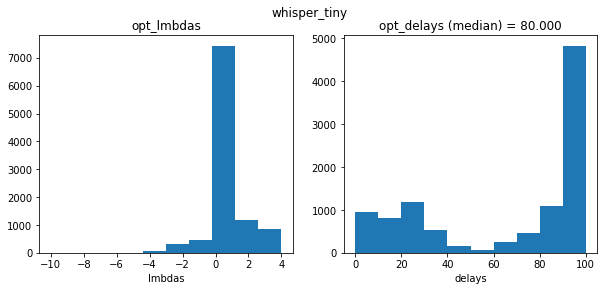

In [8]:
model_name = 'whisper_tiny'
identifier = 'test_all_trials_lmbdas'
# identifier = 'test_lmbdas_delays'
# identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


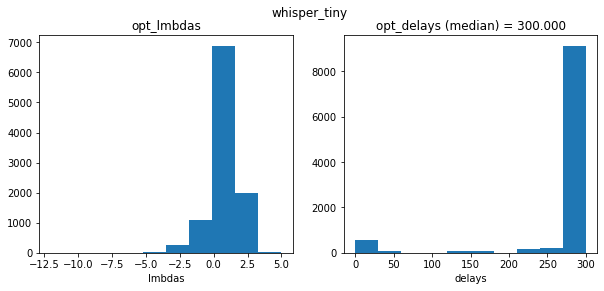

In [9]:
model_name = 'whisper_tiny'
# identifier = 'test_all_trials_lmbdas'
identifier = 'test_lmbdas_delays'
# identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


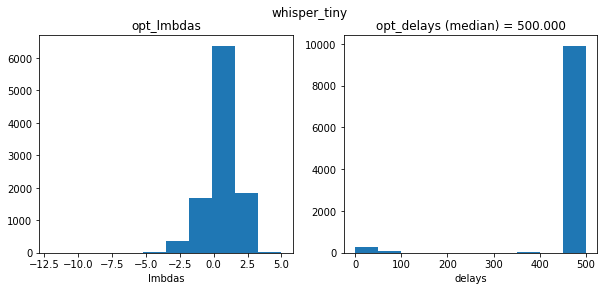

In [10]:
model_name = 'whisper_tiny'
# identifier = 'test_all_trials_lmbdas'
# identifier = 'test_lmbdas_delays'
identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


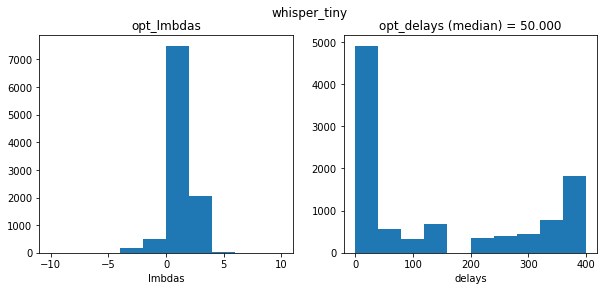

In [7]:
model_name = 'whisper_tiny'
# identifier = 'test_all_trials_lmbdas'
# identifier = 'test_lmbdas_delays'
# identifier = 'delays_500'
identifier = 'delays_trimmed'
plot_optimal_lmbdas_and_delays(model_name, identifier)

### Delays (core vs belt)

In [9]:
def get_lmbdas_primary_vs_non_primary(model_name, identifier):
	corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
	area='core'
	threshold= corr_obj.get_normalizer_threshold(
		bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	)
	data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
			neural_area=area, bin_width=bin_width, delay=delay,
			threshold=threshold, normalized=normalized,
			column=column, use_stat_inclusion=use_stat_inclusion,
			inclusion_p_threshold=inclusion_p_threshold,
			use_poisson_null=use_poisson_null,

		)
	area='non-primary'
	threshold= corr_obj.get_normalizer_threshold(
		bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	)
	data_dist_belt = corr_obj.get_corr_all_layers_for_bin_width(
			neural_area=area, bin_width=bin_width, delay=delay,
			threshold=threshold, normalized=normalized,
			column=column, use_stat_inclusion=use_stat_inclusion,
			inclusion_p_threshold=inclusion_p_threshold,
			use_poisson_null=use_poisson_null,

		)
	return data_dist_core, data_dist_belt


#### whisper_base: delays (core vs belt)

##### identifier = test_lmbdas_delays

In [7]:
bin_width=50
delay=0
normalized=True

column='opt_delays'
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

In [14]:
def get_lmbdas_primary_vs_non_primary(model_name, identifier):
	corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
	area='core'
	threshold= corr_obj.get_normalizer_threshold(
		bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	)
	data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
			neural_area=area, bin_width=bin_width, delay=delay,
			threshold=threshold, normalized=normalized,
			column=column, use_stat_inclusion=use_stat_inclusion,
			inclusion_p_threshold=inclusion_p_threshold,
			use_poisson_null=use_poisson_null,

		)
	area='non-primary'
	threshold= corr_obj.get_normalizer_threshold(
		bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	)
	data_dist_belt = corr_obj.get_corr_all_layers_for_bin_width(
			neural_area=area, bin_width=bin_width, delay=delay,
			threshold=threshold, normalized=normalized,
			column=column, use_stat_inclusion=use_stat_inclusion,
			inclusion_p_threshold=inclusion_p_threshold,
			use_poisson_null=use_poisson_null,

		)
	return data_dist_core, data_dist_belt


In [16]:
model_name = 'deepspeech2'
identifier = 'test_lmbdas_delays'	#Done
	
data_dist_core, data_dist_belt = get_lmbdas_primary_vs_non_primary(
	model_name, identifier
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-1')

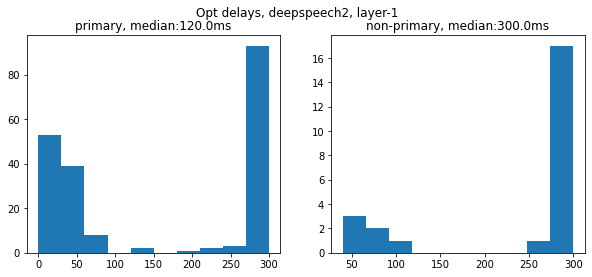

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 1
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

In [15]:

model_name = 'whisper_base'
identifier = 'test_lmbdas_delays'	#Done
	
data_dist_core, data_dist_belt = get_lmbdas_primary_vs_non_primary(
	model_name, identifier
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, whisper_base, layer-2')

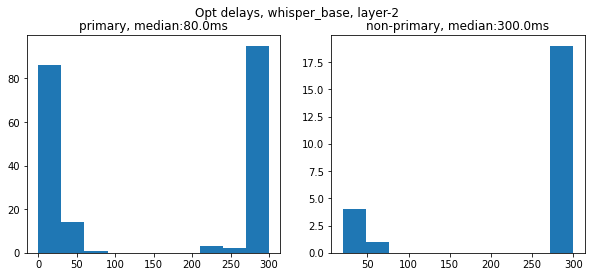

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 2
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

In [13]:
model_name = 'deepspeech2'
identifier = 'test_lmbdas_delays'	#Done
	
corr_obj = Correlations(
	model_name=model_name+'_'+identifier,
	)

Using default normalizer file...


##### test_all_trials_lmbdas

In [53]:
model_name = 'whisper_base'
identifier = 'test_all_trials_lmbdas'	#Done
	
corr_obj = Correlations(
	model_name=model_name+'_'+identifier,
	)


Using default normalizer file...


In [54]:

bin_width=50
delay=0
normalized=True

column='opt_delays'
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

In [62]:
area='core'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)
area='non-primary'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_belt = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)

Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, whisper_base, layer-0')

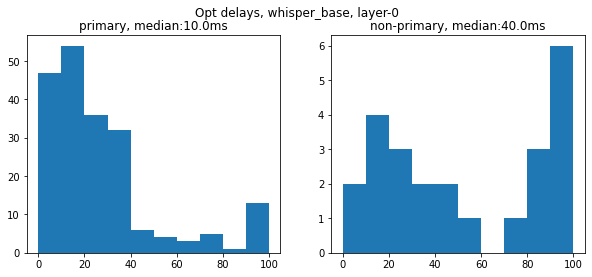

In [72]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 0
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-1')

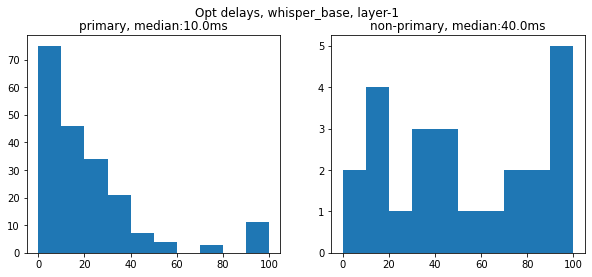

In [73]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 1
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-2')

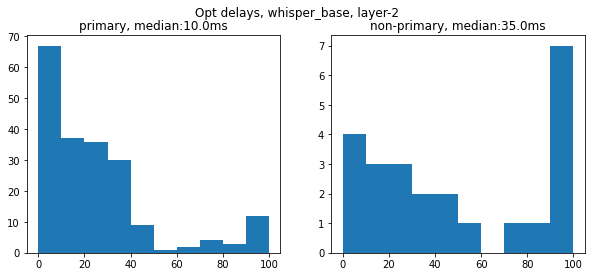

In [71]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 2
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-3')

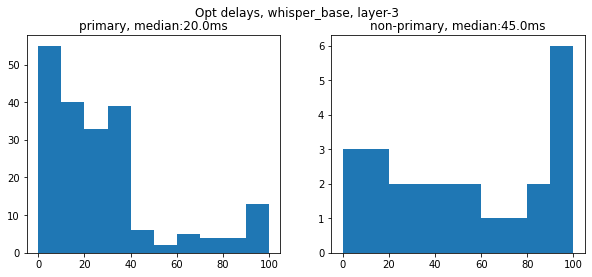

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 3
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-4')

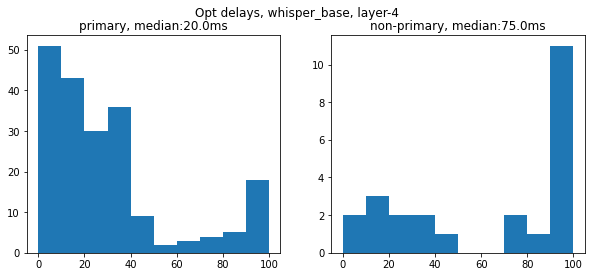

In [75]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 4
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-5')

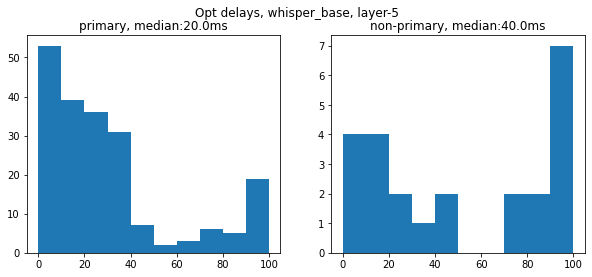

In [76]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 5
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

#### deepspeech2: delays (core vs belt)

In [78]:
model_name = 'deepspeech2'
identifier = 'test_all_trials_lmbdas'	#Done
	
corr_obj = Correlations(
	model_name=model_name+'_'+identifier,
	)


area='core'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)
area='non-primary'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_belt = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)

Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-0')

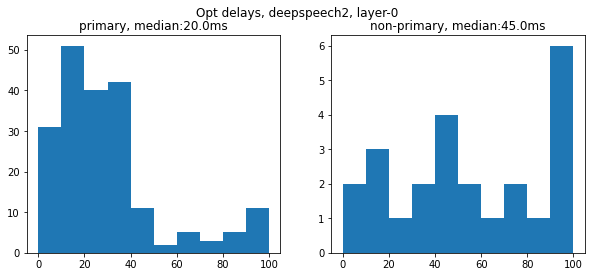

In [79]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 0
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-1')

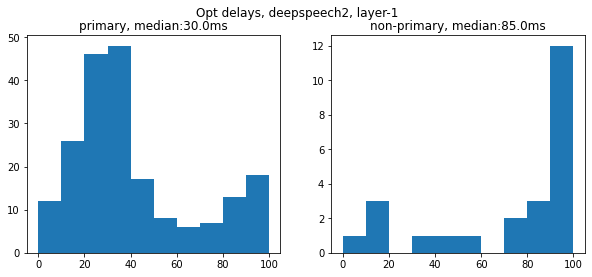

In [80]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 1
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-2')

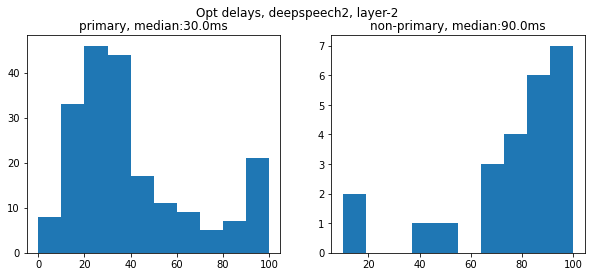

In [81]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 2
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-3')

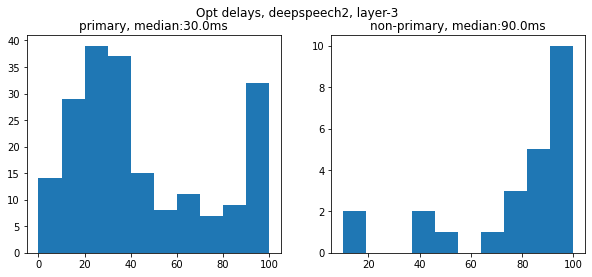

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 3
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-4')

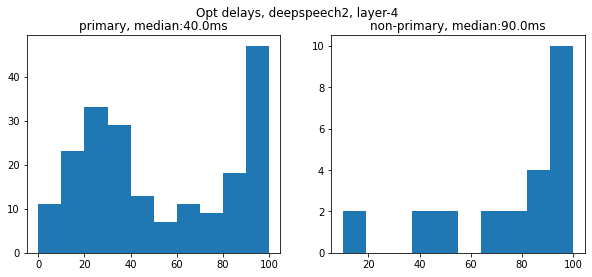

In [83]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 4
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-5')

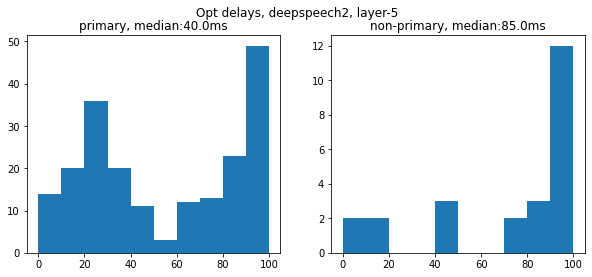

In [84]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 5
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

#### whisper_tiny

In [15]:
bin_width=50
delay=0
normalized=True

# column='opt_delays'
column='opt_lag'
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

Using default normalizer file...
Reading exisiting normalizer thresholds...
Extracting column: opt_lag
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_lag
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-3')

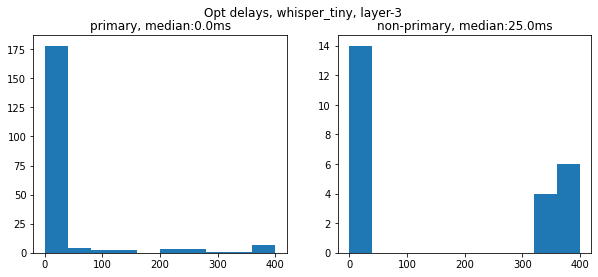

In [16]:
model_name = 'whisper_tiny'
identifier = 'delays_trimmed'	#Done
	
data_dist_core, data_dist_belt = get_lmbdas_primary_vs_non_primary(
	model_name, identifier
)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 3
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

In [12]:
bin_width=50
delay=0
normalized=True

column='opt_delays'
# column='opt_lag'
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

Using default normalizer file...
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-3')

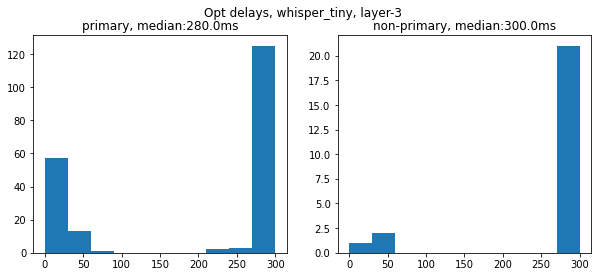

In [13]:
model_name = 'whisper_tiny'
identifier = 'test_lmbdas_delays'	#Done
	
data_dist_core, data_dist_belt = get_lmbdas_primary_vs_non_primary(
	model_name, identifier
)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 3
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Using default normalizer file...
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-3')

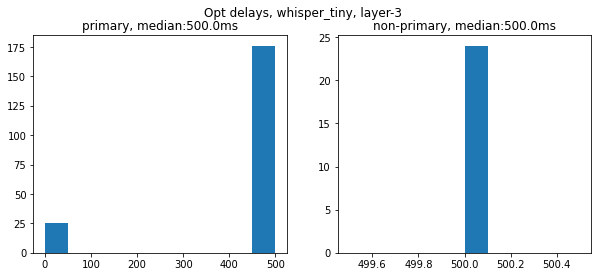

In [14]:
model_name = 'whisper_tiny'
identifier = 'delays_500'	#Done
	
data_dist_core, data_dist_belt = get_lmbdas_primary_vs_non_primary(
	model_name, identifier
)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 3
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

In [92]:
model_name = 'whisper_tiny'
identifier = 'test_all_trials_lmbdas'	#Done
	
corr_obj = Correlations(
	model_name=model_name+'_'+identifier,
	)


area='core'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)
area='non-primary'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_belt = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-1')

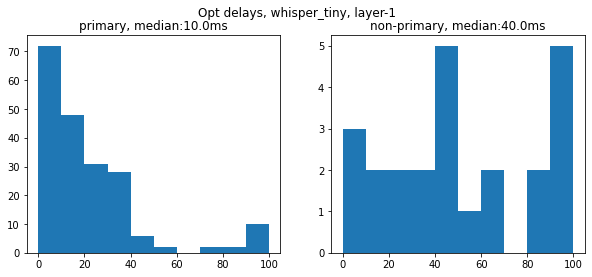

In [94]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 1
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-2')

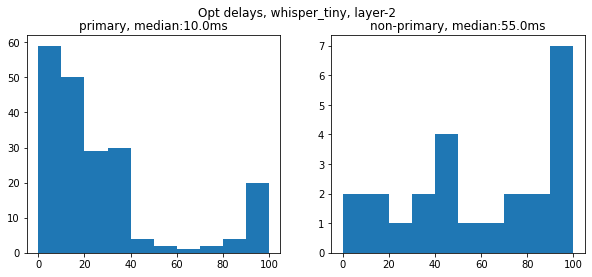

In [95]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 2
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-3')

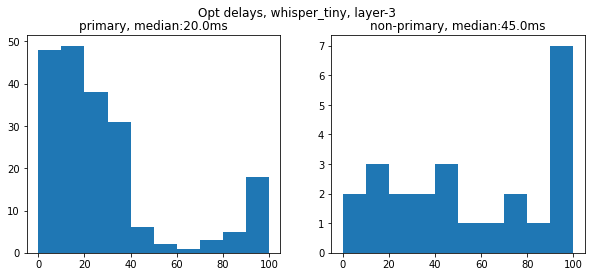

In [96]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 3
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-4')

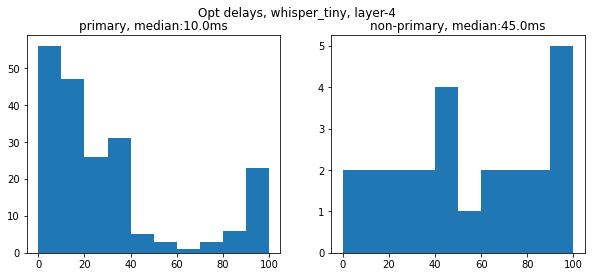

In [97]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 4
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-5')

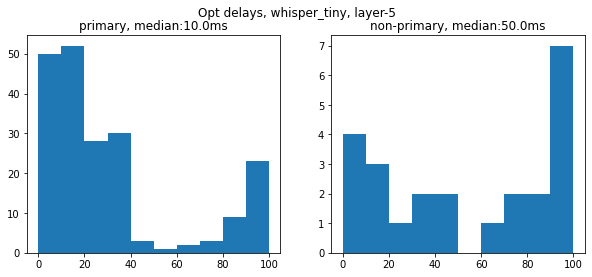

In [98]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 5
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

In [40]:
session = 180730
corr_obj.data[(corr_obj.data['opt_delays']==100)&\
	(corr_obj.data['session']==session)
	].shape

(24, 16)

### core-belt comparison

In [2]:
area='all'
bin_width=50
delay=0
alpha=0.1
save_tikz=False
normalized=True
# identifier='_bins_corrected_100',
sig_offset_x=0
sig_offset_y=0.93
sig_ind_size=8
arch_ind_offset=1.0
arch_ind_lw=8
p_threshold=0.01
plot_baseline=False 
display_inter_quartile_range=True
display_dotted_lines=True
keep_xticks = True
keep_yticks = True
trained_identifier='trained_all_bins'
untrained_identifiers=None
baseline_identifier=None
plot_difference=False
tikz_indicator=None
column=None
indicate_significance=True
indicate_architecture=True
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

In [3]:
# model_name = 'deepspeech2'
# model_name = 'whisper_base'
model_name = 'w2v2_audioset'
# trained_identifier = 'trial_0'
# trained_identifier = 'test_all_trials'
# trained_identifier = 'test_all_trials_lmbdas'
trained_identifier = 'test_lmbdas_delays'
area='core'
corr_obj_trained = Correlations(model_name+'_'+trained_identifier)
threshold= corr_obj_trained.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_trained = corr_obj_trained.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

			)
# plotting individual distributions...
color = 'green'
ax=RegPlotter.plot_line_with_shaded_region(
	data_dict=data_dist_trained, color=color, alpha=alpha,
	display_inter_quartile_range=display_inter_quartile_range,
	display_dotted_lines=display_dotted_lines,
	)
plt.ylim([0,1])
print(f"Number of samples: {data_dist_trained[0].shape}")

Using default normalizer file...


FileNotFoundError: [Errno 2] No such file or directory: '/depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/w2v2_audioset_test_all_trials_lmbdas_corr_results.csv'

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6665251349211877, occurs at x_coordinate: 7
Peak corr (max): 0.921801757827276, occurs at x_coordinate: 7
Number of samples: (24,)


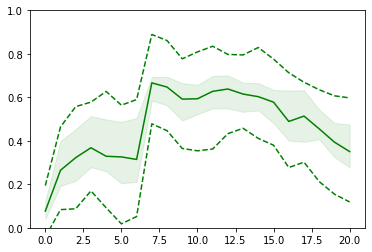

In [5]:
# model_name = 'deepspeech2'
# model_name = 'whisper_base'
model_name = 'w2v2_audioset'
# trained_identifier = 'trial_0'
# trained_identifier = 'test_all_trials'
trained_identifier = 'test_all_trials_lmbdas'
# trained_identifier = 'test_lmbdas_delays'
area='non-primary'
corr_obj_trained = Correlations(model_name+'_'+trained_identifier)
threshold= corr_obj_trained.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_trained = corr_obj_trained.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

			)
# plotting individual distributions...
color = 'green'
ax=RegPlotter.plot_line_with_shaded_region(
	data_dict=data_dist_trained, color=color, alpha=alpha,
	display_inter_quartile_range=display_inter_quartile_range,
	display_dotted_lines=display_dotted_lines,
	)
plt.ylim([0,1])
print(f"Number of samples: {data_dist_trained[0].shape}")

### core-belt comparison...

#### 'test_all_trials_lmbdas'
compares 'test_all_trials_lmbdas' (lmbdas range 10e[-12,7]) to 'test_all_trials' (lmbdas range 10e[-7,-1])

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6847060731961874, occurs at x_coordinate: 2
Peak corr (max): 0.9105909916959696, occurs at x_coordinate: 2
Peak corr (median): 0.5916055352145219, occurs at x_coordinate: 2
Peak corr (max): 0.8783695191948977, occurs at x_coordinate: 2
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thre

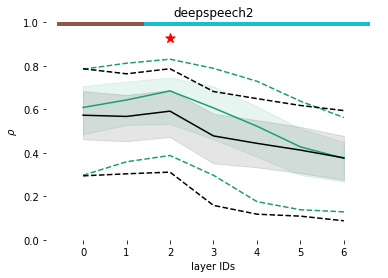

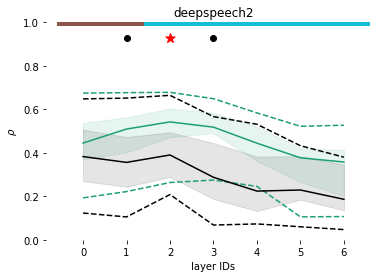

In [51]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
trained_identifier='test_all_trials'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6702589478154456, occurs at x_coordinate: 2
Peak corr (max): 0.9175154533547, occurs at x_coordinate: 2
Peak corr (median): 0.5916055352145219, occurs at x_coordinate: 2
Peak corr (max): 0.8783695191948977, occurs at x_coordinate: 2
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thresho

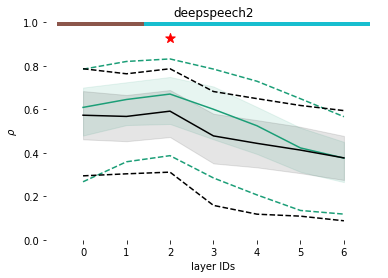

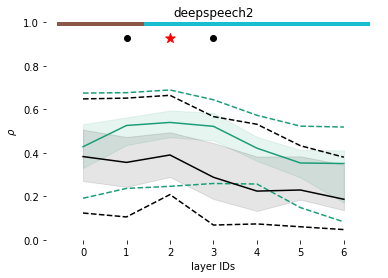

In [52]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# trained_identifier='test_all_trials'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6506755579756516, occurs at x_coordinate: 2
Peak corr (max): 0.917760671670002, occurs at x_coordinate: 1
Peak corr (median): 0.6071735705138674, occurs at x_coordinate: 1
Peak corr (max): 0.8724648383731899, occurs at x_coordinate: 3
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thres

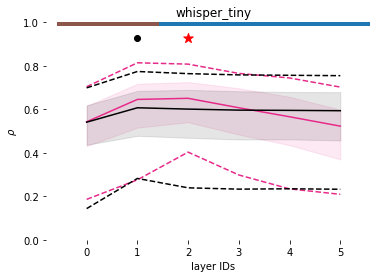

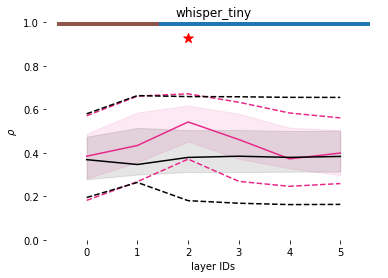

In [7]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
model_name='whisper_tiny'
# model_name='whisper_base'
trained_identifier='test_all_trials'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6438426488320306, occurs at x_coordinate: 2
Peak corr (max): 0.9177475748388562, occurs at x_coordinate: 1
Peak corr (median): 0.6071735705138674, occurs at x_coordinate: 1
Peak corr (max): 0.8724648383731899, occurs at x_coordinate: 3
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thre

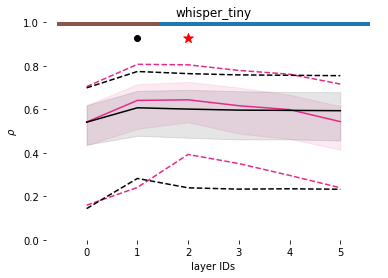

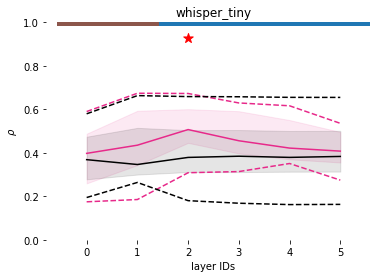

In [9]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
model_name='whisper_tiny'
# model_name='whisper_base'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6563660781835681, occurs at x_coordinate: 2
Peak corr (max): 0.9152546711808256, occurs at x_coordinate: 2
Peak corr (median): 0.6085150676463472, occurs at x_coordinate: 2
Peak corr (max): 0.8749557235158845, occurs at x_coordinate: 1
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thre

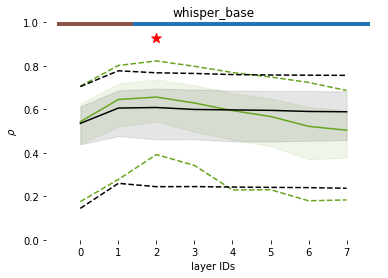

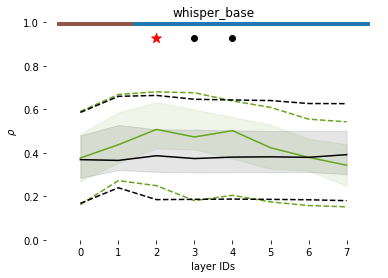

In [41]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
model_name='whisper_base'
trained_identifier='test_all_trials'
# trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.649717177303213, occurs at x_coordinate: 2
Peak corr (max): 0.9152545871038792, occurs at x_coordinate: 2
Peak corr (median): 0.6085150676463472, occurs at x_coordinate: 2
Peak corr (max): 0.8749557235158845, occurs at x_coordinate: 1
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thres

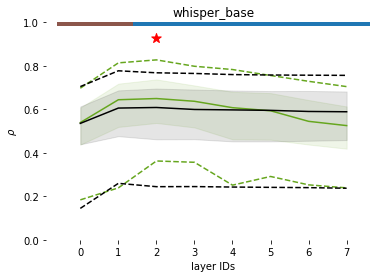

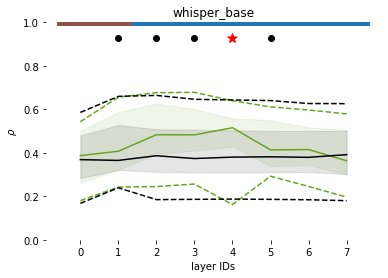

In [42]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
model_name='whisper_base'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6359928277938536, occurs at x_coordinate: 6
Peak corr (max): 0.8981545239413653, occurs at x_coordinate: 5
Peak corr (median): 0.5665019386952443, occurs at x_coordinate: 11
Peak corr (max): 0.8506403368495354, occurs at x_coordinate: 9
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thr

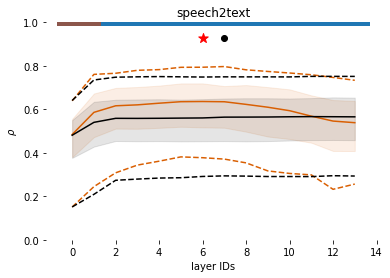

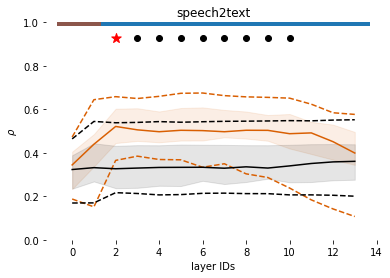

In [45]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
model_name='speech2text'
trained_identifier='test_all_trials'
# trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6362511960775113, occurs at x_coordinate: 5
Peak corr (max): 0.8735572536146705, occurs at x_coordinate: 3
Peak corr (median): 0.5665019386952443, occurs at x_coordinate: 11
Peak corr (max): 0.8506403368495354, occurs at x_coordinate: 9
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thr

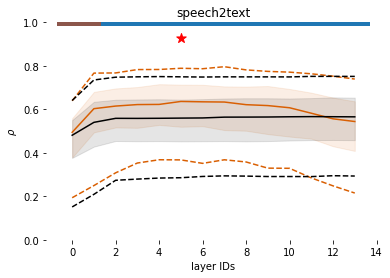

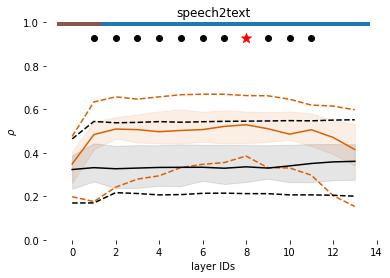

In [46]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
model_name='speech2text'
# trained_identifier='test_all_trials'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6398950323089788, occurs at x_coordinate: 8
Peak corr (max): 0.8683189205307057, occurs at x_coordinate: 9
Peak corr (median): 0.4202848666319537, occurs at x_coordinate: 17
Peak corr (max): 0.7571837486959143, occurs at x_coordinate: 1
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thr

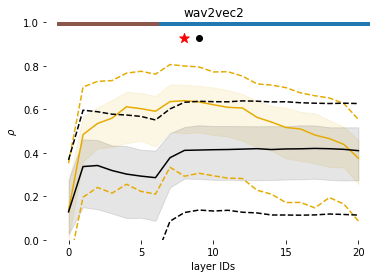

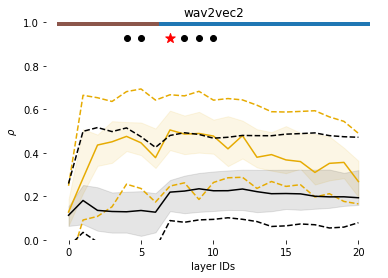

In [47]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# model_name='speech2text'
model_name='wav2vec2'
trained_identifier='test_all_trials'
# trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...


Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6395914784831926, occurs at x_coordinate: 7
Peak corr (max): 0.8617738824294442, occurs at x_coordinate: 9
Peak corr (median): 0.4202848666319537, occurs at x_coordinate: 17
Peak corr (max): 0.7571837486959143, occurs at x_coordinate: 1
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer

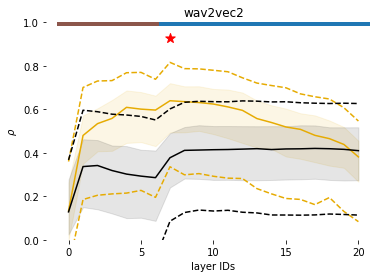

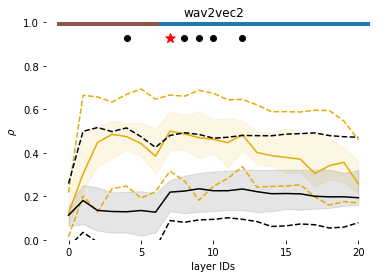

In [48]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# model_name='speech2text'
model_name='wav2vec2'
# trained_identifier='test_all_trials'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6106011761416787, occurs at x_coordinate: 4
Peak corr (max): 0.9048478700539148, occurs at x_coordinate: 5
Peak corr (median): 0.3896278703408042, occurs at x_coordinate: 0
Peak corr (max): 0.7894467077603404, occurs at x_coordinate: 0
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thre

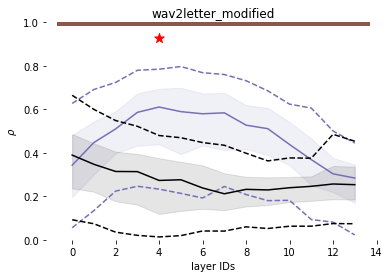

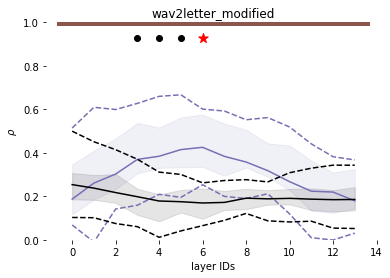

In [50]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# model_name='speech2text'
# model_name='wav2vec2'
model_name='wav2letter_modified'
trained_identifier='test_all_trials'
# trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6067559124632362, occurs at x_coordinate: 4
Peak corr (max): 0.902118506594174, occurs at x_coordinate: 5
Peak corr (median): 0.3896278703408042, occurs at x_coordinate: 0
Peak corr (max): 0.7894467077603404, occurs at x_coordinate: 0
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thres

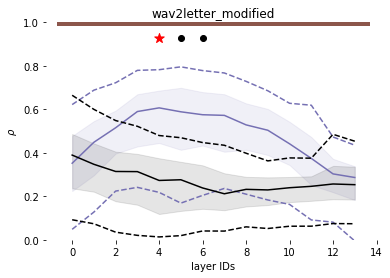

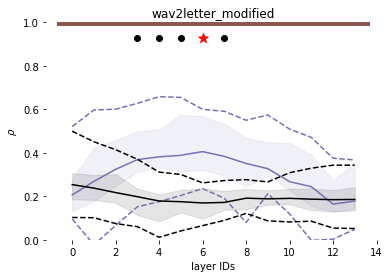

In [49]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# model_name='speech2text'
# model_name='wav2vec2'
model_name='wav2letter_modified'
# trained_identifier='test_all_trials'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

#### 'delay_500'
visualizing 'delay_500' and 'reset_delay_500'. both covering range of [0, 500] for delays..

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7244893876300617, occurs at x_coordinate: 2
Peak corr (max): 1.228014109994633, occurs at x_coordinate: 2
Peak corr (median): 0.6059953925571209, occurs at x_coordinate: 2
Peak corr (max): 1.1338453936746489, occurs at x_coordinate: 3
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7429645323022243, occurs at x_coordinate: 3
Peak corr (max): 1.1569967983393734, occurs at x_coordinate: 2
Peak corr (median): 0.6416659650530188, occurs at x_coordinate: 6
Peak corr (max): 1.0095500938909203, occurs at x_coordinate: 6
Number of neurons in dist for non-primary: 24


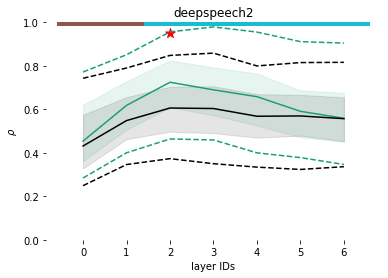

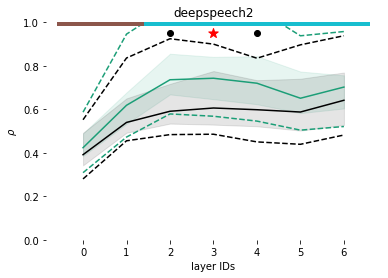

In [16]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='deepspeech2',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

2024-06-10 00:23:54.391370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 00:23:55.636285: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/gilbreth/cuda-toolkit/cuda-11.2.0/extras/CUPTI/lib64:/apps/gilbreth/cuda-toolkit/cuda-11.2.0/lib64:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/intel64/lib:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/mic/lib:/apps/spack/gilbreth/apps/intel-parallel-studio/cl

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7256873238806368, occurs at x_coordinate: 10
Peak corr (max): 1.2662830218998948, occurs at x_coordinate: 7
Peak corr (median): 0.5810905537305063, occurs at x_coordinate: 11
Peak corr (max): 1.0547744645665864, occurs at x_coordinate: 6
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.8151991887820371, occurs at x_coordinate: 11
Peak corr (max): 1.2132215715667327, occurs at x_coordinate: 13
Peak corr (median): 0.5803863614384065, occurs at x_coordinate: 13
Peak corr (max): 0.9528324830359124, occurs at x_coordinate: 5
Number of neurons in dist for non-primary

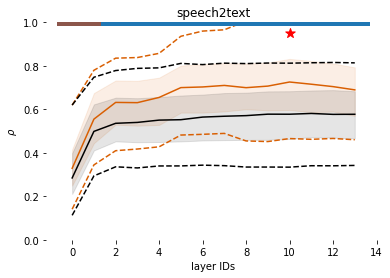

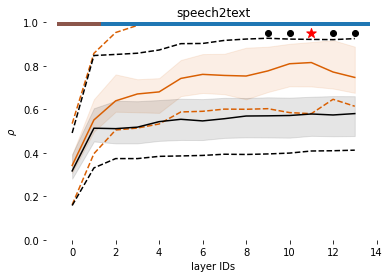

In [15]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='speech2text',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6927315119052081, occurs at x_coordinate: 4
Peak corr (max): 1.2709909192315685, occurs at x_coordinate: 4
Peak corr (median): 0.5470472287391978, occurs at x_coordinate: 2
Peak corr (max): 0.9075329761477032, occurs at x_coordinate: 2
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.754035728430541, occurs at x_coordinate: 5
Peak corr (max): 1.1534268580480558, occurs at x_coordinate: 5
Peak corr (median): 0.5230614917766186, occurs at x_coordinate: 2
Peak corr (max): 0.9499910191992014, occurs at x_coordinate: 2
Number of neurons in dist for non-primary: 24


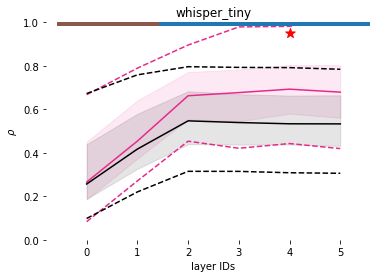

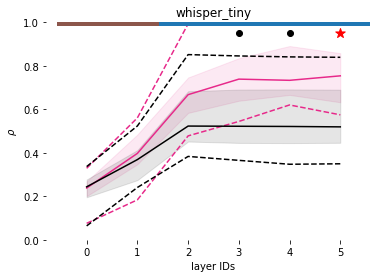

In [17]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='whisper_tiny',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7047409754108921, occurs at x_coordinate: 3
Peak corr (max): 1.280574462136335, occurs at x_coordinate: 6
Peak corr (median): 0.5392828173512548, occurs at x_coordinate: 2
Peak corr (max): 0.9052834687047924, occurs at x_coordinate: 2
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7587920064490108, occurs at x_coordinate: 7
Peak corr (max): 1.138852111690003, occurs at x_coordinate: 3
Peak corr (median): 0.5318076594118557, occurs at x_coordinate: 2
Peak corr (max): 0.9708167247789128, occurs at x_coordinate: 2
Number of neurons in dist for non-primary: 24


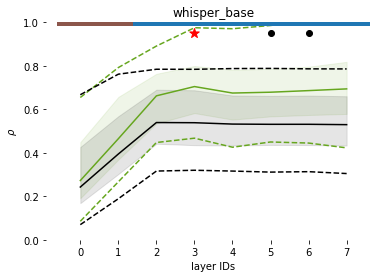

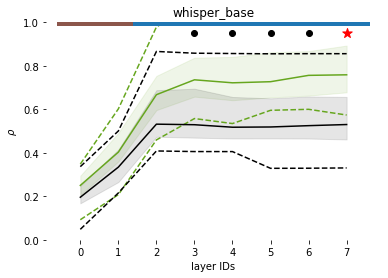

In [18]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='whisper_base',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.5523832490387329, occurs at x_coordinate: 9
Peak corr (max): 1.06947604574774, occurs at x_coordinate: 12
Peak corr (median): 0.6781444542665119, occurs at x_coordinate: 12
Peak corr (max): 1.376752487056371, occurs at x_coordinate: 12
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6257575867975589, occurs at x_coordinate: 10
Peak corr (max): 0.9595677647226872, occurs at x_coordinate: 12
Peak corr (median): 0.8219378657318026, occurs at x_coordinate: 12
Peak corr (max): 1.2911747284904294, occurs at x_coordinate: 12
Number of neurons in dist for non-primary:

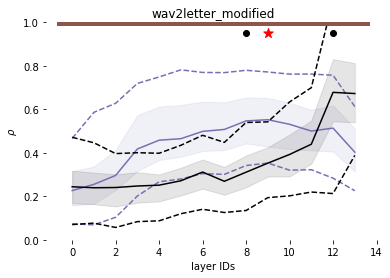

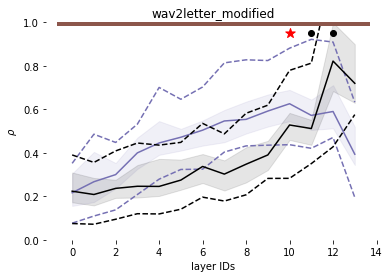

In [19]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='wav2letter_modified',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.726039852261714, occurs at x_coordinate: 7
Peak corr (max): 1.2934253026173108, occurs at x_coordinate: 8
Peak corr (median): 0.6118220109433073, occurs at x_coordinate: 10
Peak corr (max): 1.1884717734405772, occurs at x_coordinate: 9
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7741582566305528, occurs at x_coordinate: 9
Peak corr (max): 1.1534842610446203, occurs at x_coordinate: 7
Peak corr (median): 0.6866986176586359, occurs at x_coordinate: 16
Peak corr (max): 1.066877955669839, occurs at x_coordinate: 20
Number of neurons in dist for non-primary: 24

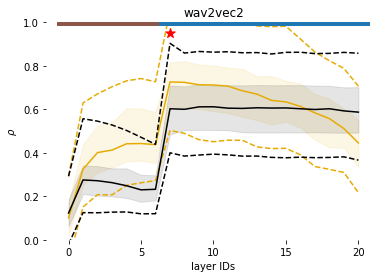

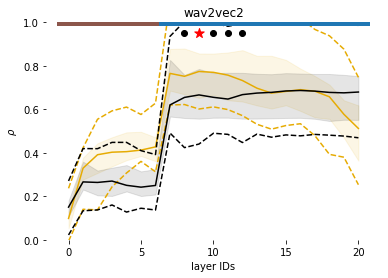

In [20]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='wav2vec2',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
model_name 'w2v2_audioset' not recognizable!!!
Peak corr (median): 0.7545091508919969, occurs at x_coordinate: 7
Peak corr (max): 1.3016959227061888, occurs at x_coordinate: 7
Peak corr (median): 0.603259646225699, occurs at x_coordinate: 7
Peak corr (max): 1.1946128821173194, occurs at x_coordinate: 7
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
model_name 'w2v2_audioset' not recognizable!!!
Peak corr (median): 0.7566168185347935, occurs at x_coordinate: 14
Peak corr (max): 1.1558349301233255, occurs at x_coordinate: 7
Peak corr (median): 0.6814122612343207, occurs at x_coordinate: 10
Peak corr (max

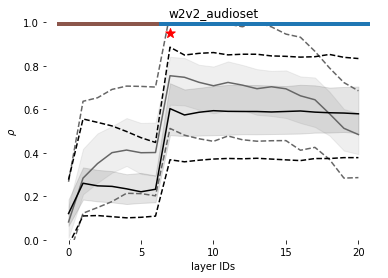

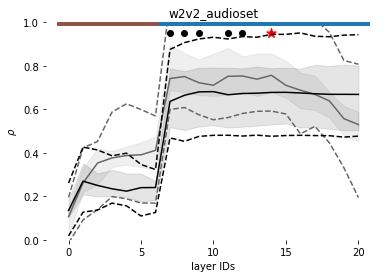

In [21]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='w2v2_audioset',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

### neural predictions at high delay

In [28]:
model_name = 'whisper_base'
identifier = 'delays_500'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

Using default normalizer file...


In [30]:
corr_obj.data[(corr_obj.data['session']==200206)& \
	(corr_obj.data['channel']==32)
			]

,session,layer,channel,bin_width,delay,train_cc_raw,test_cc_raw,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,normalizer,N_sents,opt_delays,opt_lmbdas,layer_type,normalized_test_cc
10376,200206.0,0.0,32.0,50.0,0.0,0.0,0.548284,494.402655,0.551641,-0.547288,0.704778,500.0,20.0,-4.0,conv,0.653099
10440,200206.0,1.0,32.0,50.0,0.0,0.0,0.688147,5308.309639,5.941251,-5.936935,0.704778,500.0,0.0,-3.0,conv,0.819701
10504,200206.0,2.0,32.0,50.0,0.0,0.0,0.675709,5036.928578,5.620071,-5.615717,0.704778,500.0,20.0,-8.0,transformer,0.804885
10568,200206.0,3.0,32.0,50.0,0.0,0.0,0.683490,2132.880389,2.387196,-2.382881,0.704778,500.0,0.0,-2.0,transformer,0.814153
10632,200206.0,4.0,32.0,50.0,0.0,0.0,0.643187,1187.958298,1.325492,-1.321138,0.704778,500.0,20.0,-1.0,transformer,0.766145
10696,200206.0,5.0,32.0,50.0,0.0,0.0,0.623937,586.155872,0.654017,-0.649663,0.704778,500.0,20.0,-1.0,transformer,0.743215
10760,200206.0,6.0,32.0,50.0,0.0,0.0,0.593646,464.032433,0.517755,-0.513401,0.704778,500.0,20.0,0.0,transformer,0.707133
10824,200206.0,7.0,32.0,50.0,0.0,0.0,0.575651,280.727887,0.313229,-0.308875,0.704778,500.0,20.0,1.0,transformer,0.685699


In [49]:
model_name = 'whisper_base'

dataloader = DataLoader()
reg_obj = Regression(model_name)

Using default normalizer file...
Creating regression obj for: 'whisper_base'
Using default normalizer file...


In [54]:
from auditory_cortex.plotters.tikzplots import plot_spike_counts

def trials_and_predictions(
	reg_obj,
	dataloader,
	model_name,
	session, 
	delay,
	bin_width,
	sent_ids,
	layer,
	ch,
	):
	force_reload=False
	predicted_spike_rate = {}
	predicted_spike_rate[model_name] = reg_obj.neural_prediction(
		session, bin_width=bin_width, delay=delay, sents=sent_ids, layer_IDs=[layer],
		force_reload=force_reload
		)

	trial_color = 'gray'
	mean_color = 'k'
	prediction_colors = None
	ind_trial_width=1
	mean_line_width=2
	alpha = 0.8


	all_trials = dataloader.get_neural_data_for_repeated_trials(
			session, bin_width=bin_width, delay=delay,
			sent_IDs=sent_ids
		)

	ax = plot_spike_counts(
		bin_width,
		ch, all_trials, predicted_spike_rate,
		trial_color, mean_color, prediction_colors,
		ind_trial_width, mean_line_width, alpha=alpha
	)
	corr = utils.compute_avg_test_corr(
		all_trials[...,ch],
		predicted_spike_rate[model_name][:,ch].squeeze())

	ax.set_title(f"{model_name}, bw-{bin_width}, delay-{delay}, Corr={corr[0]:.3f}")

#### core session - 200206

Reading raw features from /scratch/gilbreth/ahmedb/cache/whisper_base/whisper_base_raw_features.pkl
Resamping ANN features at bin-width: 50
DataLoader: Extracting spikes for session-200206...Loading Neural data for session: 200206 ... Done.
Reading neural spikes from dataset object. 
# of iterations requested: 1, 
                 # of lambda samples per iteration: 20
Itr: 1:
5_fold CV for session: 200206
For fold=0: 
For fold=1: 
For fold=2: 
For fold=3: 
For fold=4: 
It takes (on avg.) 3.99 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 2.74 sec/mapping.
It takes (on avg.) 0.11 minutes/iteration...!
Loading Neural data for session: 200206 ... Done.


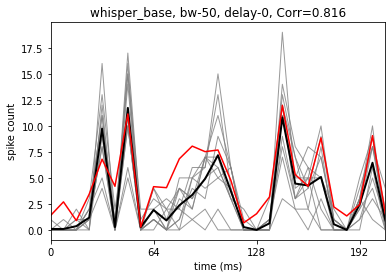

In [50]:
session = 200206
bin_width = 50
delay=0
sent_ids = [12]
layer = 2

trials_and_predictions(
	reg_obj, dataloader, model_name, session, delay, 
	bin_width, sent_ids, layer, ch,
)

# of iterations requested: 1, 
                 # of lambda samples per iteration: 20
Itr: 1:
5_fold CV for session: 200206
For fold=0: 
DataLoader: Extracting spikes for session-200206...Reading neural spikes from dataset object. 
For fold=1: 
For fold=2: 
For fold=3: 
For fold=4: 
It takes (on avg.) 12.46 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 2.60 sec/mapping.
It takes (on avg.) 0.25 minutes/iteration...!


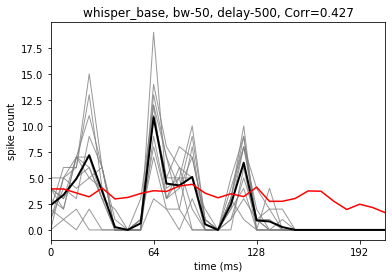

In [51]:
session = 200206
bin_width = 50
delay=500
sent_ids = [12]
layer = 2

trials_and_predictions(
	reg_obj, dataloader, model_name, session, delay, 
	bin_width, sent_ids, layer, ch,
)

#### non-primary session..

In [3]:
model_name = 'whisper_base'
identifier = 'delays_500'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

Using default normalizer file...


In [4]:
bin_width=50
delay=0
normalized=True

column='session'
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

area='non-primary'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)

Reading exisiting normalizer thresholds...
Extracting column: session
Retreiving data using normalizer threshold..


In [5]:
np.unique(data_dist_core[2])

array([180613., 180728., 180730., 191121., 191210., 200205., 200219.])

In [12]:
corr_obj.data[(corr_obj.data['session']==200205) &\
	(corr_obj.data['normalizer']>threshold) &\
	(corr_obj.data['layer']==2)
	]

,session,layer,channel,bin_width,delay,train_cc_raw,test_cc_raw,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,normalizer,N_sents,opt_delays,opt_lmbdas,layer_type,normalized_test_cc
9986,200205.0,2.0,2.0,50.0,0.0,0.0,0.314214,2.038156,0.011953,-0.004244,0.104780,500.0,500.0,0.0,transformer,0.970704
9987,200205.0,2.0,3.0,50.0,0.0,0.0,0.249079,1.929047,0.010308,-0.003332,0.173801,500.0,500.0,0.0,transformer,0.597463
9993,200205.0,2.0,9.0,50.0,0.0,0.0,0.312498,1.850336,0.012189,-0.004270,0.094071,500.0,500.0,0.0,transformer,1.018872
9994,200205.0,2.0,10.0,50.0,0.0,0.0,0.251494,2.018651,0.009073,-0.002539,0.144301,500.0,500.0,-1.0,transformer,0.662053
9996,200205.0,2.0,12.0,50.0,0.0,0.0,0.318646,1.983615,0.009668,-0.002608,0.105701,500.0,500.0,-1.0,transformer,0.980093
10005,200205.0,2.0,21.0,50.0,0.0,0.0,0.219815,2.149682,0.011659,-0.004055,0.094499,500.0,500.0,-1.0,transformer,0.715062
10027,200205.0,2.0,43.0,50.0,0.0,0.0,0.225538,1.776266,0.010633,-0.003059,0.131598,500.0,500.0,0.0,transformer,0.621718
10030,200205.0,2.0,46.0,50.0,0.0,0.0,0.140120,1.587349,0.014136,-0.005079,0.098669,500.0,500.0,0.0,transformer,0.446076
10042,200205.0,2.0,58.0,50.0,0.0,0.0,0.268493,1.964065,0.009053,-0.002362,0.165953,500.0,500.0,0.0,transformer,0.659083


In [46]:
corr_obj.data[(corr_obj.data['session']==180728) &\
	(corr_obj.data['normalizer']>threshold) &\
	(corr_obj.data['layer']==2)
	]

,session,layer,channel,bin_width,delay,train_cc_raw,test_cc_raw,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,normalizer,N_sents,opt_delays,opt_lmbdas,layer_type,normalized_test_cc
1444,180728.0,2.0,4.0,50.0,0.0,0.0,0.253486,1.698457,0.017016,-0.007775,0.141999,500.0,500.0,0.0,transformer,0.672685
1445,180728.0,2.0,5.0,50.0,0.0,0.0,0.231382,1.673321,0.014994,-0.006023,0.100337,500.0,500.0,0.0,transformer,0.730465


# of iterations requested: 1, 
                 # of lambda samples per iteration: 20
Itr: 1:
5_fold CV for session: 180728
For fold=0: 
For fold=1: 
For fold=2: 
For fold=3: 
For fold=4: 
It takes (on avg.) 3.99 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 0.62 sec/mapping.
It takes (on avg.) 0.08 minutes/iteration...!


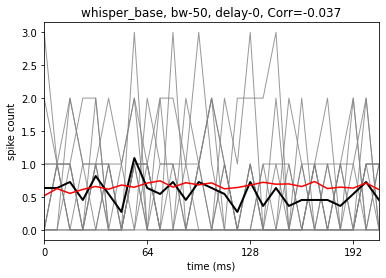

In [55]:
session = 180728
bin_width = 50
delay=0
sent_ids = [12]
layer = 2
ch = 4

trials_and_predictions(
	reg_obj, dataloader, model_name, session, delay, 
	bin_width, sent_ids, layer, ch,
)

# of iterations requested: 1, 
                 # of lambda samples per iteration: 20
Itr: 1:
5_fold CV for session: 180728
For fold=0: 
DataLoader: Extracting spikes for session-180728...Reading neural spikes from dataset object. 
For fold=1: 
For fold=2: 
For fold=3: 
For fold=4: 
It takes (on avg.) 4.58 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 0.62 sec/mapping.
It takes (on avg.) 0.09 minutes/iteration...!


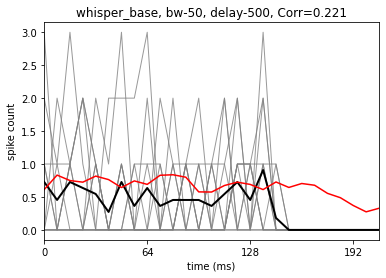

In [56]:
session = 180728
bin_width = 50
delay=500
sent_ids = [12]
layer = 2

trials_and_predictions(
	reg_obj, dataloader, model_name, session, delay, 
	bin_width, sent_ids, layer, ch,
)

### TRF results

In [2]:
area='all'
bin_width=50
delay=0
alpha=0.1
save_tikz=False
normalized=True
# identifier='_bins_corrected_100',
sig_offset_x=0
sig_offset_y=0.93
sig_ind_size=8
arch_ind_offset=1.0
arch_ind_lw=8
p_threshold=0.01
plot_baseline=False 
display_inter_quartile_range=True
display_dotted_lines=True
keep_xticks = True
keep_yticks = True
trained_identifier='trained_all_bins'
untrained_identifiers=None
baseline_identifier=None
plot_difference=False
tikz_indicator=None
column=None
indicate_significance=True
indicate_architecture=True
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6538969766331664, occurs at x_coordinate: 1
Peak corr (max): 0.9143117942055502, occurs at x_coordinate: 1
Number of samples: (201,)


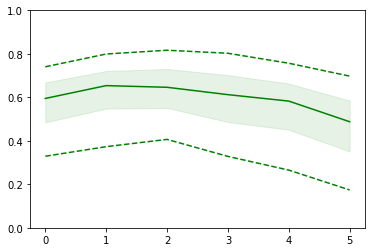

In [3]:
# model_name = 'deepspeech2'
model_name = 'whisper_tiny'
# model_name = 'w2v2_audioset'

trained_identifier = 'trf_300'
area='core'
corr_obj_trained = Correlations(model_name+'_'+trained_identifier)
threshold= corr_obj_trained.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_trained = corr_obj_trained.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

			)
# plotting individual distributions...
color = 'green'
ax=RegPlotter.plot_line_with_shaded_region(
	data_dict=data_dist_trained, color=color, alpha=alpha,
	display_inter_quartile_range=display_inter_quartile_range,
	display_dotted_lines=display_dotted_lines,
	)
plt.ylim([0,1])
print(f"Number of samples: {data_dist_trained[0].shape}")

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Peak corr (median): 0.5481855897377955, occurs at x_coordinate: 2
Peak corr (max): 0.6959754435144245, occurs at x_coordinate: 2
Number of samples: (24,)


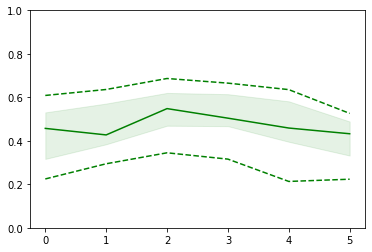

In [4]:
# model_name = 'deepspeech2'
model_name = 'whisper_tiny'
# model_name = 'w2v2_audioset'

trained_identifier = 'trf_300'
area='non-primary'
corr_obj_trained = Correlations(model_name+'_'+trained_identifier)
threshold= corr_obj_trained.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_trained = corr_obj_trained.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

			)
# plotting individual distributions...
color = 'green'
ax=RegPlotter.plot_line_with_shaded_region(
	data_dict=data_dist_trained, color=color, alpha=alpha,
	display_inter_quartile_range=display_inter_quartile_range,
	display_dotted_lines=display_dotted_lines,
	)
plt.ylim([0,1])
print(f"Number of samples: {data_dist_trained[0].shape}")